# 计算机网络体系结构第一次作业

## 实验设置

买卖的最小单位是一手，即 100 份。

### 买入

若忽略起点，买入费率为 0.038%

- 考虑买入证券交易费：过户费、佣金
- 过户费：按成交证券的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = deltaPosition * stockToday["收盘"]
costBuy = deltaPositionValue*0.02/1e3 + max(deltaPositionValue*0.018/100, 5)
#self.cash -= deltaPosition * stockToday["收盘"]
self.cash = self.cash - deltaPositionValue - costBuy

#没有考虑self.cash不够，出现负数的情况
```

### 卖出

若忽略起点，买入费率为 0.043%

- 考虑买入证券交易费：印花税、过户费、佣金
- 印花税：单向收取，卖出成交金额的万分之五（5‱）印花税由政府收取
- 过户费：按成交股票的金额 ×0.02‰收取，单位：元。双向收取（上海市场均收取）,过户费属于证券登记清算机构的收入
- 佣金：买卖双向收取，成交金额的 0.015%－0.3%，起点 5 元。此处取 0.018%

```python
deltaPositionValue = pos["头寸"] * stockToday["收盘"]
costSell = deltaPositionValue*(1e-3 + 0.02/1e3) + max(deltaPositionValue*0.018/100, 5)
```


## 实验代码及说明


### 准备依赖


In [88]:
# !python -m pip install akshare joblib matplotlib numpy pandas PyPortfolioOpt scipy

In [89]:
import akshare as ak
import calendar
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pylab import mpl
import os

# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False

### 准备实验数据


In [90]:
stockNameCodes: list[tuple[str, str]] = [
    ("512200", "房地产ETF"),
    ("513050", "中概互联网ETF"),
    ("510300", "沪深300ETF"),
    ("510050", "上证50ETF"),
    ("510500", "中证500ETF"),
    ("159915", "创业板ETF"),
    ("159902", "中小100ETF"),
    ("512010", "医药ETF"),
    ("512880", "证券ETF"),
    ("512580", "环保ETF"),
    ("159920", "恒生ETF"),
    ("510900", "H股ETF"),
    ("513500", "标普500ETF"),
    ("513100", "纳指ETF"),
    ("512660", "军工ETF"),
    ("512800", "银行ETF"),
    # ("512400", "有色ETF"),
    ("512980", "传媒ETF"),
    ("511010", "国债ETF"),
    ("511260", "十年国债ETF"),
]


def Preprocess(startDate: datetime.datetime, endDate: datetime.datetime):
    # 获取标的历史数据
    startDate = startDate - datetime.timedelta(days=365)

    allStockDaily: dict[str, pd.DataFrame] = {}
    path = f'data/{startDate.strftime("%Y")}-{endDate.strftime("%Y")}'
    if os.path.exists(path):
        print(f'使用已有数据({startDate.strftime("%Y")}-{endDate.strftime("%Y")})')
        for code, name in stockNameCodes:
            try:
                stockDaily = pd.read_csv(os.path.join(
                    path, f"{name}_{code}.csv"), sep=',')
                stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])
                stockDaily = stockDaily.set_index("日期", drop=False)

                allStockDaily[code] = stockDaily
            except:
                print(f'{name}({code})读取失败!')
                continue
        return allStockDaily

    os.makedirs(path)
    for i, (code, name) in enumerate(stockNameCodes):
        print(f"{i}. {name}({code}) 正在读取数据...")
        try:
            # stockDaily = ak.stock_zh_a_hist(
            stockDaily = ak.fund_etf_hist_em(
                symbol=code,
                period="daily",
                start_date=startDate.strftime("%Y%m%d"),
                end_date=endDate.strftime("%Y%m%d"),
                adjust="hfq",
            )
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}读取失败!'
            )
            continue
        try:
            # print(stockDaily.columns)
            stockDaily = stockDaily[stockDaily["开盘"].notnull()]
            stockDaily["日期"] = pd.to_datetime(stockDaily["日期"])

            stockDaily.to_csv(os.path.join(
                path, f"{name}_{code}.csv"), index=False)
            stockDaily = stockDaily.set_index("日期", drop=False)

            allStockDaily[code] = stockDaily
        except:
            print(
                f'{name}({code}): {startDate.strftime("%Y-%m-%d")}--{endDate.strftime("%Y-%m-%d")}处理失败!'
            )
            continue
    return allStockDaily


start = datetime.datetime(2017, 9, 1)
end = datetime.datetime(2024, 3, 14)
print(f"{start.strftime('%Y-%m-%d')}到{end.strftime('%Y-%m-%d')}共计 {(end-start).days} 天")
allStockDaily = Preprocess(start, end)
print(f"共有{len(allStockDaily)}个标的数据")

2017-09-01到2024-03-14共计 2386 天
使用已有数据(2016-2024)
共有19个标的数据


<Axes: title={'center': '各 ETF 走势'}, xlabel='日期'>

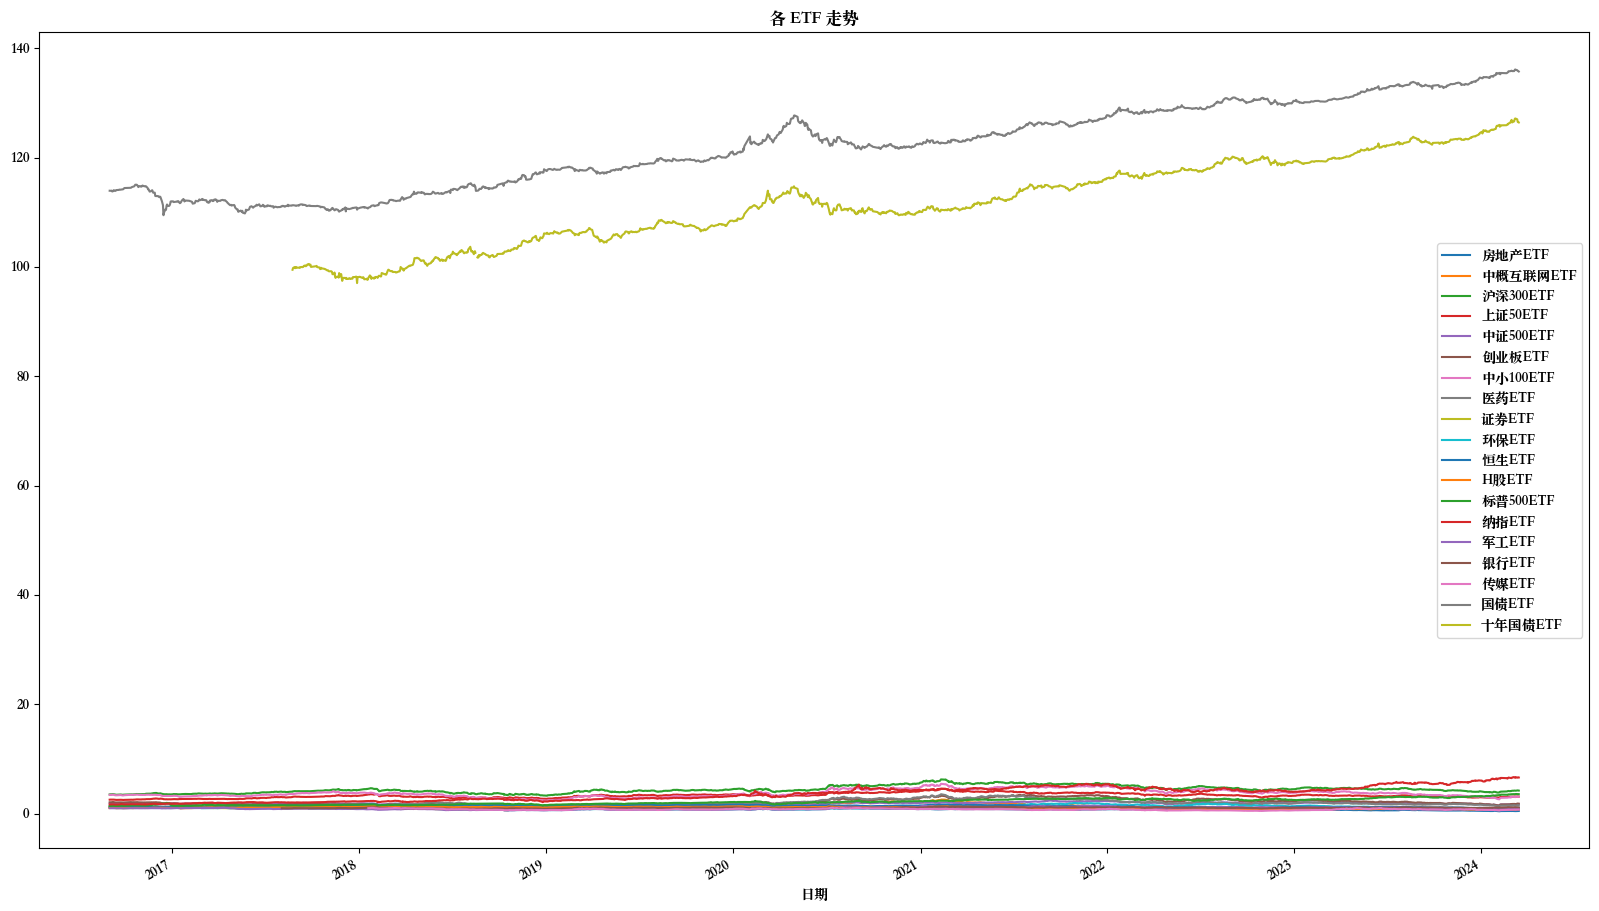

In [91]:
# 股价走势
df_prices: pd.DataFrame = pd.concat([i.iloc[:, 2]
                                     for _, i in allStockDaily.items()], keys=[i[1] for i in stockNameCodes], axis=1)
df_prices.to_csv("data/prices.csv")
df_prices.plot(figsize=(20, 12), title='各 ETF 走势')

<Axes: title={'center': '各 ETF 走势（初始值标准化为 1）'}, xlabel='日期'>

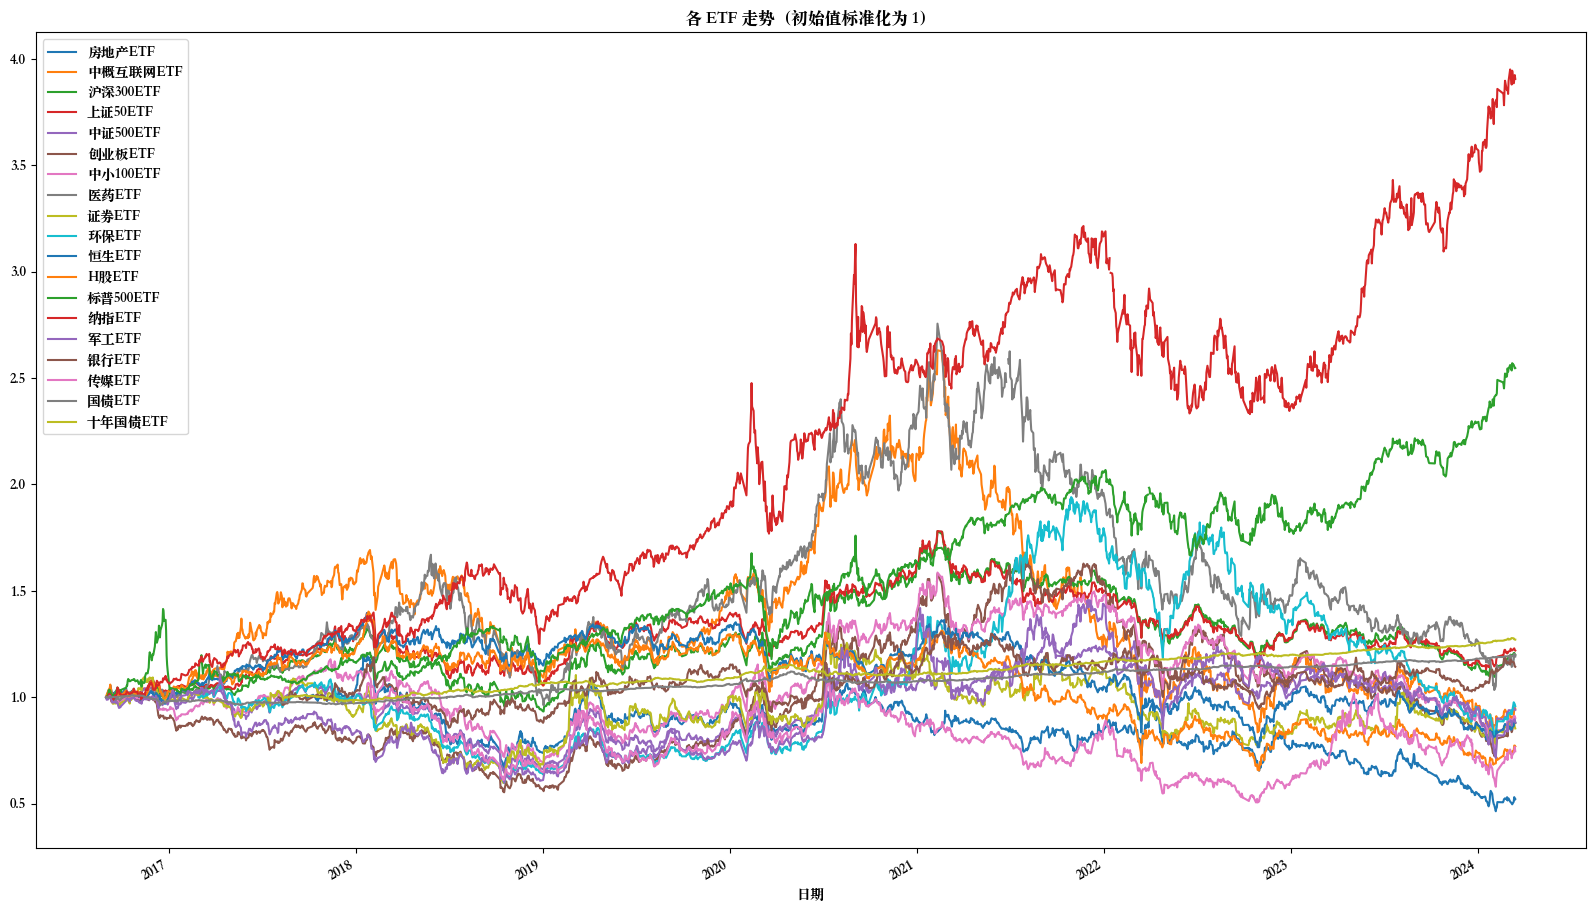

In [92]:
# 股价（初始值标准化为 1）走势
prices_normalized: pd.DataFrame = pd.concat([i.iloc[:, 2]/i.iloc[0, 2]
                                             for _, i in allStockDaily.items()], keys=[i[1] for i in stockNameCodes], axis=1)
prices_normalized.to_csv("data/prices_normalized.csv")
prices_normalized.plot(figsize=(20, 12), title='各 ETF 走势（初始值标准化为 1）')

In [93]:
class ExtraCost:
    '''
    记录交易费用：过户费、佣金、印花税。
    '''
    __counter = 0
    __silent = False
    __warn = False

    def __init__(self, silent: bool = False):
        self.__silent = silent

    def get(self):
        return self.__counter

    def buy(self, num: float, store: bool):
        assert num >= 0, "买入数量必须不小于 0。"
        if num > 0:
            brokerage = round(num * 18 / 1e5, 2)
            if self.__warn and brokerage < 5:
                print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
            extra = round(round(num / 5000, 2) + max(5, brokerage), 2)
            if store:
                self.__counter += extra
            return round(num + extra, 2)
        else:
            if self.__warn:
                print("资金不足，无法购买。")
            return 0

    def sell(self, num: float, store: bool):
        assert num >= 0, "卖出数量必须不小于 0。"
        if num > 0:
            brokerage = round(num * 18 / 1e5, 2)
            if self.__warn and brokerage < 5:
                print(f"{brokerage} < 5，感觉浪费了，请调大一点投资周期（或增加投资资金）。")
            extra = round(round(num / 4000, 2) + max(5, brokerage), 2)
            if store:
                self.__counter += extra
            return round(num - extra, 2)
        else:
            return 0


# 1 表示开盘，2 表示收盘
D = 2
DN = '收盘'

### 实验设置

In [94]:
# 交易周期
deltas = [
    datetime.timedelta(days=1),  # 日
    datetime.timedelta(days=3),  # 三日
    datetime.timedelta(days=7),  # 周
    datetime.timedelta(days=15),  # 半月
    datetime.timedelta(days=30),  # 月
    datetime.timedelta(days=90),  # 季度
    datetime.timedelta(days=180),  # 半年
    datetime.timedelta(days=365),  # 年
    datetime.timedelta(days=3000),  # 一次性买入
]

### 实验内容

#### 单个 ETF 上的测试

##### 对定期等额平均成本投资法的验证


In [95]:
from dataclasses import dataclass


@dataclass
class Result:
    # 最终资产与投入资金的比例
    asset: float
    # 最终基金价格与首日基金价格的比例
    ratio: float
    # 交易费用
    extra: float
    # 最大回撤
    max_drawdown: float
    # 平均回撤
    avg_drawdown: float
    # 总期数
    periods: int


def calc(stockNameCode: tuple[str, str], step: datetime.timedelta, silent: bool = False) -> Result:
    '''
    Returns a tuple of (asset, ratio)
    '''
    df = allStockDaily[stockNameCode[0]]

    # 开始时间
    START = max(df.iloc[0, 0], start)
    END = min(df.iloc[-1, 0], end)

    # 总期数
    PERIODS_TOTAL: int = (END-START)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = START
    # 初始资金：每期五千
    # 似乎有点少，但是这样可以更好地体现出投资的风险
    INIT = 5000 * PERIODS_TOTAL
    money = INIT
    # 股票数量
    stocks = 0
    extra = ExtraCost(silent=silent)

    min_asset = 1
    record_assets: list[float] = []

    if not silent:
        print(f"开始计算{stockNameCode[1]}")
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1
    for date, row in df.iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price: float = row.iloc[D]
        # 当前资产
        asset_now = ((money+extra.sell(stocks*price, store=False))
                     if stocks > 0 else money)/INIT
        min_asset = min(min_asset, asset_now)
        record_assets.append(asset_now)
        l.append(pd.DataFrame([{'日期': date, '资产': asset_now}]))
        if cur <= date:
            # 本期准备使用的资金金额，大约每期 5000
            period_money = money/periods

            # 本期准备购买的基金数量（以 100 份为单位）
            stock_count = period_money//price//100

            # 本期准备购买的基金总价
            stock_price = stock_count*100*price
            while money < extra.buy(stock_price, store=False):
                stock_count -= 1
                stock_price = stock_count*100*price
                assert stock_count >= 0, f"剩余资金 {money} 不足以购买一手基金"
            money -= extra.buy(stock_price, store=True)
            assert money >= 0
            money = round(money, 2)
            stocks += stock_count*100
            if not silent:
                STOCK_PRICE = extra.sell(stocks*price, store=False)
                print(
                    f"第 {i} / {PERIODS_TOTAL} 期（{date}）: {money} + {STOCK_PRICE} = {round(money+STOCK_PRICE, 2)}")
            cur += step
            i += 1
            periods -= 1

    if not silent:
        ax = plt.axes(title=stockNameCode[1])
        # 当日与首日基金价格的比例
        normalized = df.iloc[:, D]/df.iloc[0, D]
        # 不太能理解的是这个地方为什么不能正常显示标签。
        normalized.plot(ax=ax, x='日期', y='开盘', label='当日开盘价与首日开盘价的比值')

        # 当日资金与投入资金的比例
        asset = pd.DataFrame(columns=['日期', '资产'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=False, inplace=True)
        asset.plot(ax=ax, x='日期', y='资产', label='当日资产与初始资产的比值')
    price: float = df.iloc[-1, D]
    ratio: float = price/df.iloc[0, D]
    final = round(extra.sell(stocks*price, store=True), 2)
    asset_ratio = round(final+money, 2)/INIT
    max_drawdown = 1-min_asset
    avg_drawdown = 1-np.mean(record_assets)
    if not silent:
        print(f"剩余资金：{money}")
        print(f"基金数量：{stocks}")
        print(f"股价：{price}")
        print(f"股价比值（末日与首日）：{ratio}")
        print(f"基金名称：{stockNameCode[1]}")
        print(f"交易费用：{extra.get()}")
        print(f"最大回撤：{max_drawdown}")
        print(f"平均回撤；{avg_drawdown}")
        print(f"最终资产：{final} + {money} = {round(final+money,2)}")
        print(f"最终资产比值（末日与首日）：{asset_ratio}")
    return Result(asset_ratio, ratio, extra.get(), max_drawdown, avg_drawdown, PERIODS_TOTAL)

开始计算房地产ETF
总期数：27
开始时间：2017-09-25 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-25 00:00:00）: 130054.01 + 4933.76 = 134987.77
第 2 / 27 期（2017-12-25 00:00:00）: 125092.42 + 9903.72 = 134996.14
第 3 / 27 期（2018-03-26 00:00:00）: 120107.62 + 14558.96 = 134666.58
第 4 / 27 期（2018-06-22 00:00:00）: 115177.44 + 18328.82 = 133506.26
第 5 / 27 期（2018-09-20 00:00:00）: 110237.95 + 21317.57 = 131555.52
第 6 / 27 期（2018-12-19 00:00:00）: 105261.16 + 25500.52 = 130761.68
第 7 / 27 期（2019-03-19 00:00:00）: 100310.27 + 37490.47 = 137800.74
第 8 / 27 期（2019-06-17 00:00:00）: 95310.47 + 39588.97 = 134899.44
第 9 / 27 期（2019-09-16 00:00:00）: 90362.58 + 44804.62 = 135167.2
第 10 / 27 期（2019-12-16 00:00:00）: 85417.39 + 50516.87 = 135934.26
第 11 / 27 期（2020-03-13 00:00:00）: 80390.49 + 53760.07 = 134150.56
第 12 / 27 期（2020-06-11 00:00:00）: 75374.49 + 57757.15 = 133131.64
第 13 / 27 期（2020-09-09 00:00:00）: 70428.5 + 70649.61 = 141078.11
第 14 / 27 期（2020-12-08 00:00:00）: 65450.51 + 72198.54 = 137649.05
第 15 / 27 期（2021-03-08 00:0

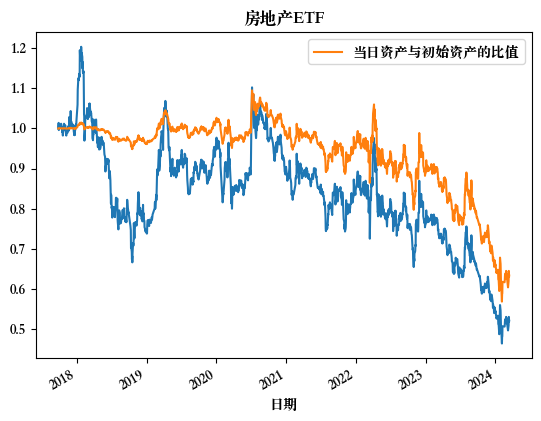

开始计算上证50ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 130027.61 + 4960.16 = 134987.77
第 2 / 27 期（2017-11-30 00:00:00）: 125137.63 + 10086.08 = 135223.71
第 3 / 27 期（2018-02-28 00:00:00）: 120228.15 + 15028.64 = 135256.79
第 4 / 27 期（2018-05-29 00:00:00）: 115337.37 + 18918.87 = 134256.24
第 5 / 27 期（2018-08-27 00:00:00）: 110581.02 + 23147.41 = 133728.43
第 6 / 27 期（2018-11-26 00:00:00）: 105733.45 + 27044.24 = 132777.69
第 7 / 27 期（2019-02-25 00:00:00）: 100832.97 + 35877.57 = 136710.54
第 8 / 27 期（2019-05-24 00:00:00）: 95806.17 + 39521.8 = 135327.97
第 9 / 27 期（2019-08-22 00:00:00）: 91082.23 + 47159.72 = 138241.95
第 10 / 27 期（2019-11-20 00:00:00）: 86232.26 + 53261.09 = 139493.35
第 11 / 27 期（2020-02-18 00:00:00）: 81456.51 + 57212.99 = 138669.5
第 12 / 27 期（2020-05-18 00:00:00）: 76460.01 + 60857.92 = 137317.93
第 13 / 27 期（2020-08-17 00:00:00）: 71368.39 + 76642.23 = 148010.62
第 14 / 27 期（2020-11-16 00:00:00）: 66654.85 + 81563.31 = 148218.16
第 15 / 27 期（2021-02-18 00

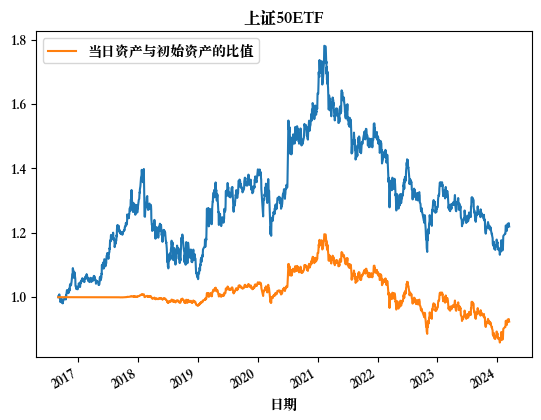

开始计算创业板ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 130021.21 + 4966.56 = 134987.77
第 2 / 27 期（2017-11-30 00:00:00）: 125026.21 + 9637.99 = 134664.2
第 3 / 27 期（2018-02-28 00:00:00）: 120067.22 + 14520.17 = 134587.39
第 4 / 27 期（2018-05-29 00:00:00）: 115195.05 + 19622.69 = 134817.74
第 5 / 27 期（2018-08-27 00:00:00）: 110198.05 + 21664.78 = 131862.83
第 6 / 27 期（2018-11-26 00:00:00）: 105216.05 + 23873.83 = 129089.88
第 7 / 27 期（2019-02-25 00:00:00）: 100286.47 + 33555.57 = 133842.04
第 8 / 27 期（2019-05-24 00:00:00）: 95298.07 + 36106.87 = 131404.94
第 9 / 27 期（2019-08-22 00:00:00）: 90319.28 + 45512.62 = 135831.9
第 10 / 27 期（2019-11-20 00:00:00）: 85348.29 + 53433.52 = 138781.81
第 11 / 27 期（2020-02-18 00:00:00）: 80326.29 + 72491.82 = 152818.11
第 12 / 27 期（2020-05-18 00:00:00）: 75426.71 + 75614.37 = 151041.08
第 13 / 27 期（2020-08-17 00:00:00）: 70467.42 + 101629.28 = 172096.7
第 14 / 27 期（2020-11-16 00:00:00）: 65483.42 + 107111.92 = 172595.34
第 15 / 27 期（2021-02-18 00:

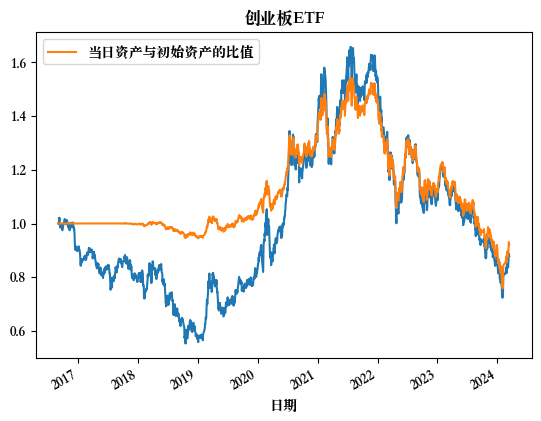

开始计算标普500ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 130030.81 + 4956.96 = 134987.77
第 2 / 27 期（2017-11-30 00:00:00）: 125058.62 + 10245.24 = 135303.86
第 3 / 27 期（2018-02-28 00:00:00）: 120183.65 + 15247.39 = 135431.04
第 4 / 27 期（2018-05-29 00:00:00）: 115323.68 + 20053.18 = 135376.86
第 5 / 27 期（2018-08-27 00:00:00）: 110401.0 + 27485.23 = 137886.23
第 6 / 27 期（2018-11-26 00:00:00）: 105456.31 + 30640.82 = 136097.13
第 7 / 27 期（2019-02-25 00:00:00）: 100578.34 + 36176.44 = 136754.78
第 8 / 27 期（2019-05-24 00:00:00）: 95674.56 + 42610.67 = 138285.23
第 9 / 27 期（2019-08-22 00:00:00）: 90653.16 + 50325.25 = 140978.41
第 10 / 27 期（2019-11-20 00:00:00）: 85719.97 + 58485.34 = 144205.31
第 11 / 27 期（2020-02-18 00:00:00）: 80807.99 + 68431.56 = 149239.55
第 12 / 27 期（2020-05-18 00:00:00）: 75768.38 + 64441.08 = 140209.46
第 13 / 27 期（2020-08-17 00:00:00）: 70896.01 + 78492.24 = 149388.25
第 14 / 27 期（2020-11-16 00:00:00）: 65957.62 + 84487.06 = 150444.68
第 15 / 27 期（2021-02-18 

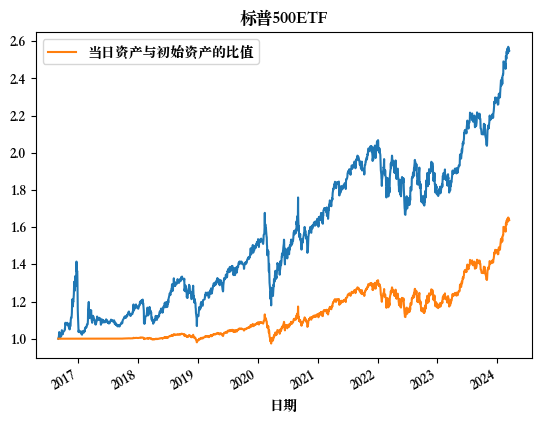

In [96]:
# 以房地产 ETF、上证 50 ETF、创业板 ETF、标普 500 ETF 为例
for i in [0, 3, 5, 12]:
    calc(stockNameCodes[i], datetime.timedelta(days=90))
    plt.show()

In [97]:
results: list[list[tuple[datetime.timedelta, Result]]] = []
res: list[pd.DataFrame] = []
for stockNameCode in stockNameCodes:
    results.append([])
    l: list[pd.DataFrame] = []
    for delta in deltas:
        r = calc(stockNameCode, delta, silent=True)
        final = r.asset
        ratio_1 = r.ratio
        extra = r.extra
        mdd = r.max_drawdown
        avgdd = r.avg_drawdown
        results[-1].append((delta, r))
        l.append(pd.DataFrame({
            "标的": stockNameCode[1], "投资周期": [delta],
            "价格比例": [ratio_1], "最终资金与投入资金的比例": [final],
            "交易费用": [extra],
            "最大回撤": [mdd], "平均回撤": [avgdd]
        }))
    res.append(pd.concat(l))
pd.concat(res).to_csv('result.csv', index=False)

In [98]:
table1: list[pd.DataFrame] = []
table2: list[pd.DataFrame] = []
table3: list[pd.DataFrame] = []
for i, l in enumerate(results):
    d1: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    d2: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    d3: dict[str, str | float] = {'标的': stockNameCodes[i][1], }
    for j, delta in enumerate(deltas):
        key = str(l[j][0].days)+" 天"
        d1[key] = l[j][1].asset
        d2[key] = l[j][1].max_drawdown
        d3[key] = l[j][1].avg_drawdown
    table1.append(pd.DataFrame.from_dict(d1, orient='index').T)
    table2.append(pd.DataFrame.from_dict(d2, orient='index').T)
    table3.append(pd.DataFrame.from_dict(d3, orient='index').T)

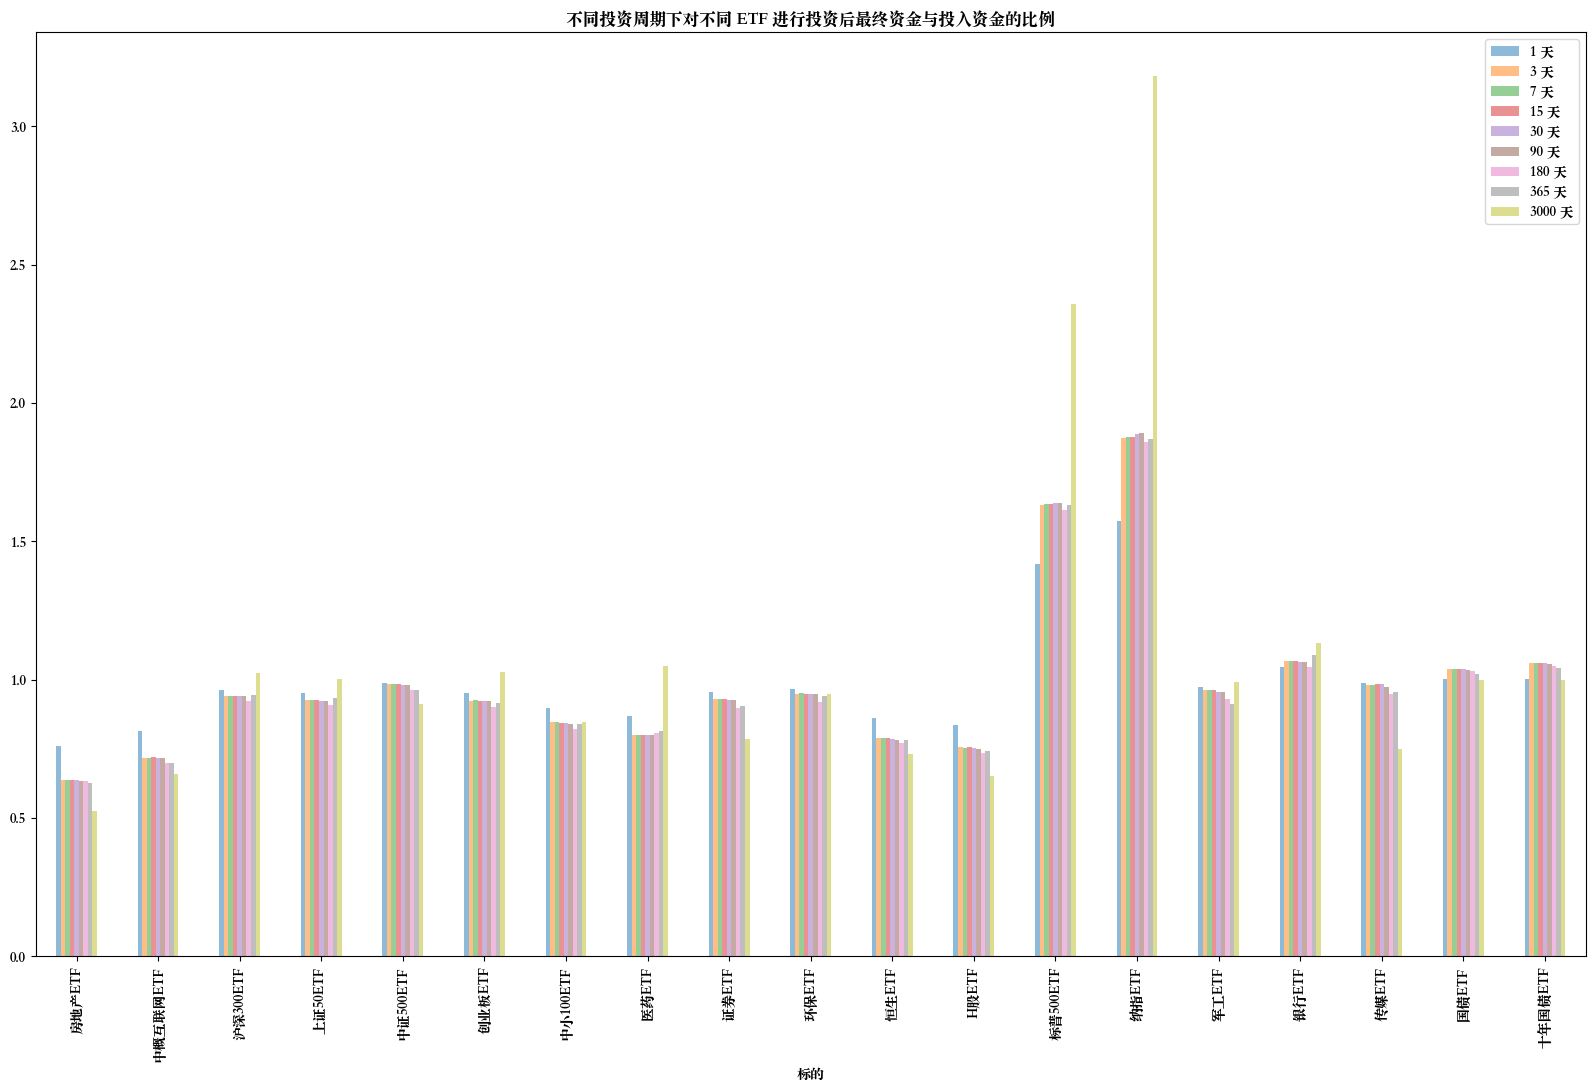

In [99]:
# 不同投资周期下使用每期五千元对不同标的进行投资后，最终资金与投入资金的比例。
# 表格中高亮部分对应该标的收益最高的投资周期。

t = pd.concat(table1)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
# print(t.idxmax(axis=1))
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资后最终资金与投入资金的比例')
t.style.format(precision=3).highlight_max(axis='columns')

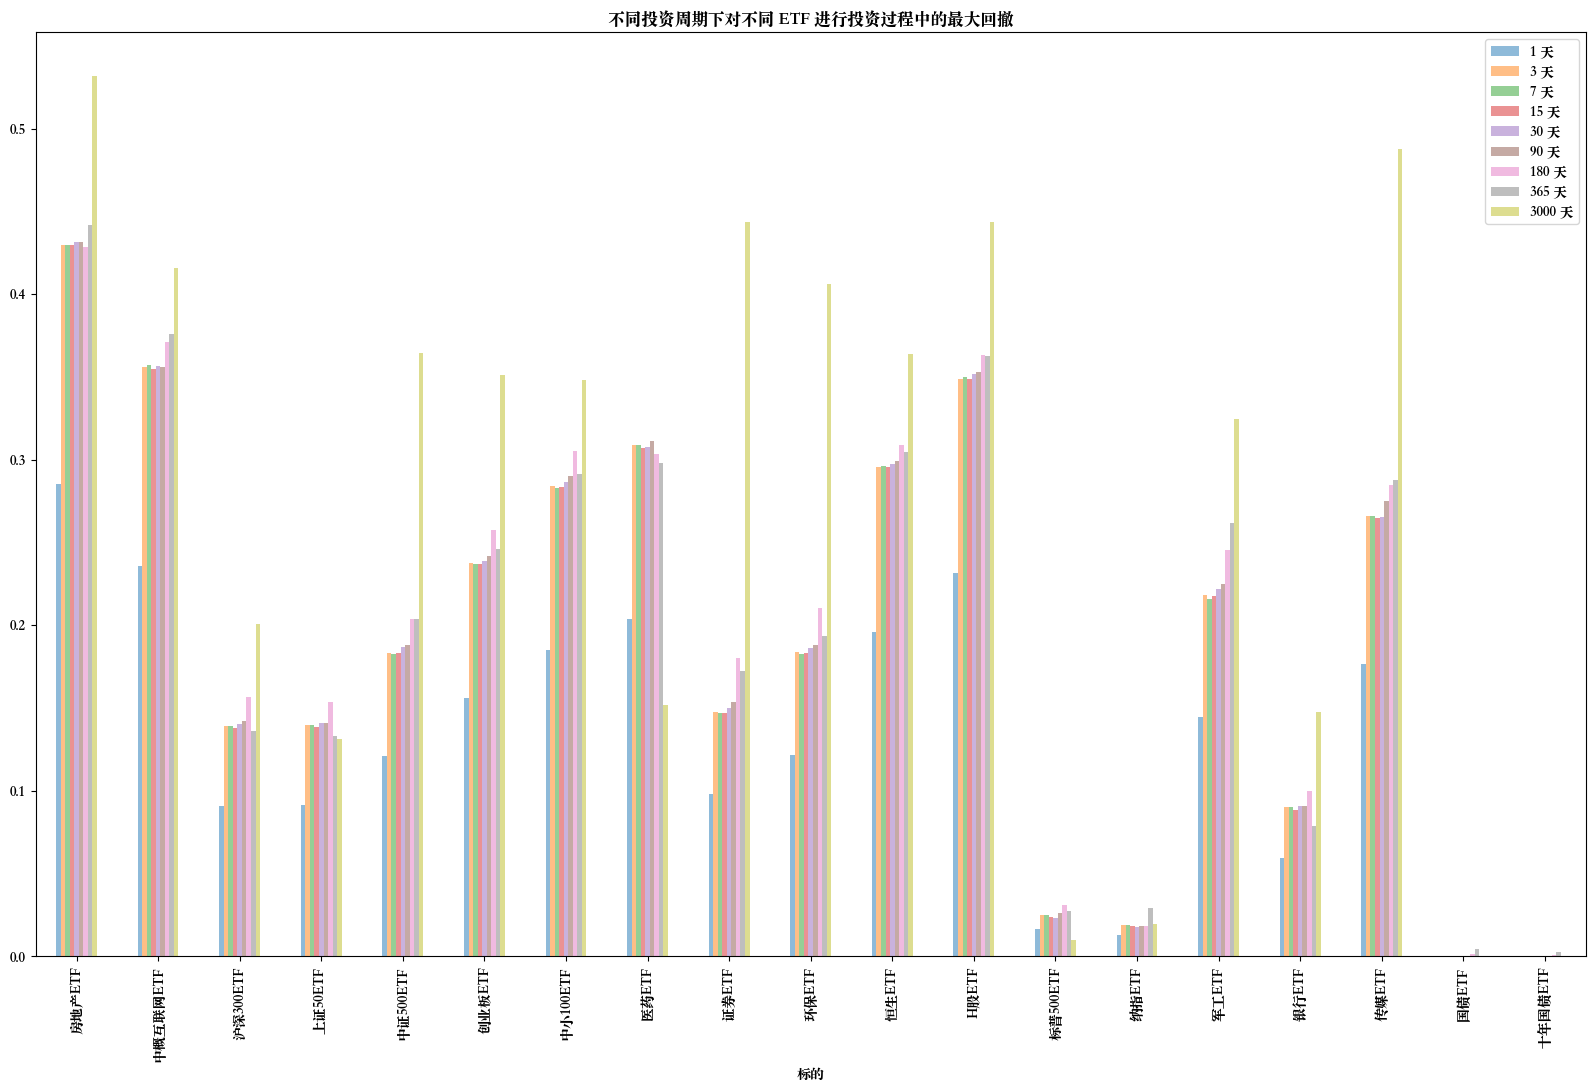

In [100]:
# 不同投资周期下使用每期五千元对不同标的进行投资过程中的最大回撤。
# 表格中高亮部分对应该标的的最大回撤的最大、最小值。

t = pd.concat(table2)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
t.plot(kind='bar', alpha=0.5, figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资过程中的最大回撤')
t.style.format(precision=3).highlight_min(axis='columns', color='lightgreen').highlight_max(axis='columns', color='lightcoral')

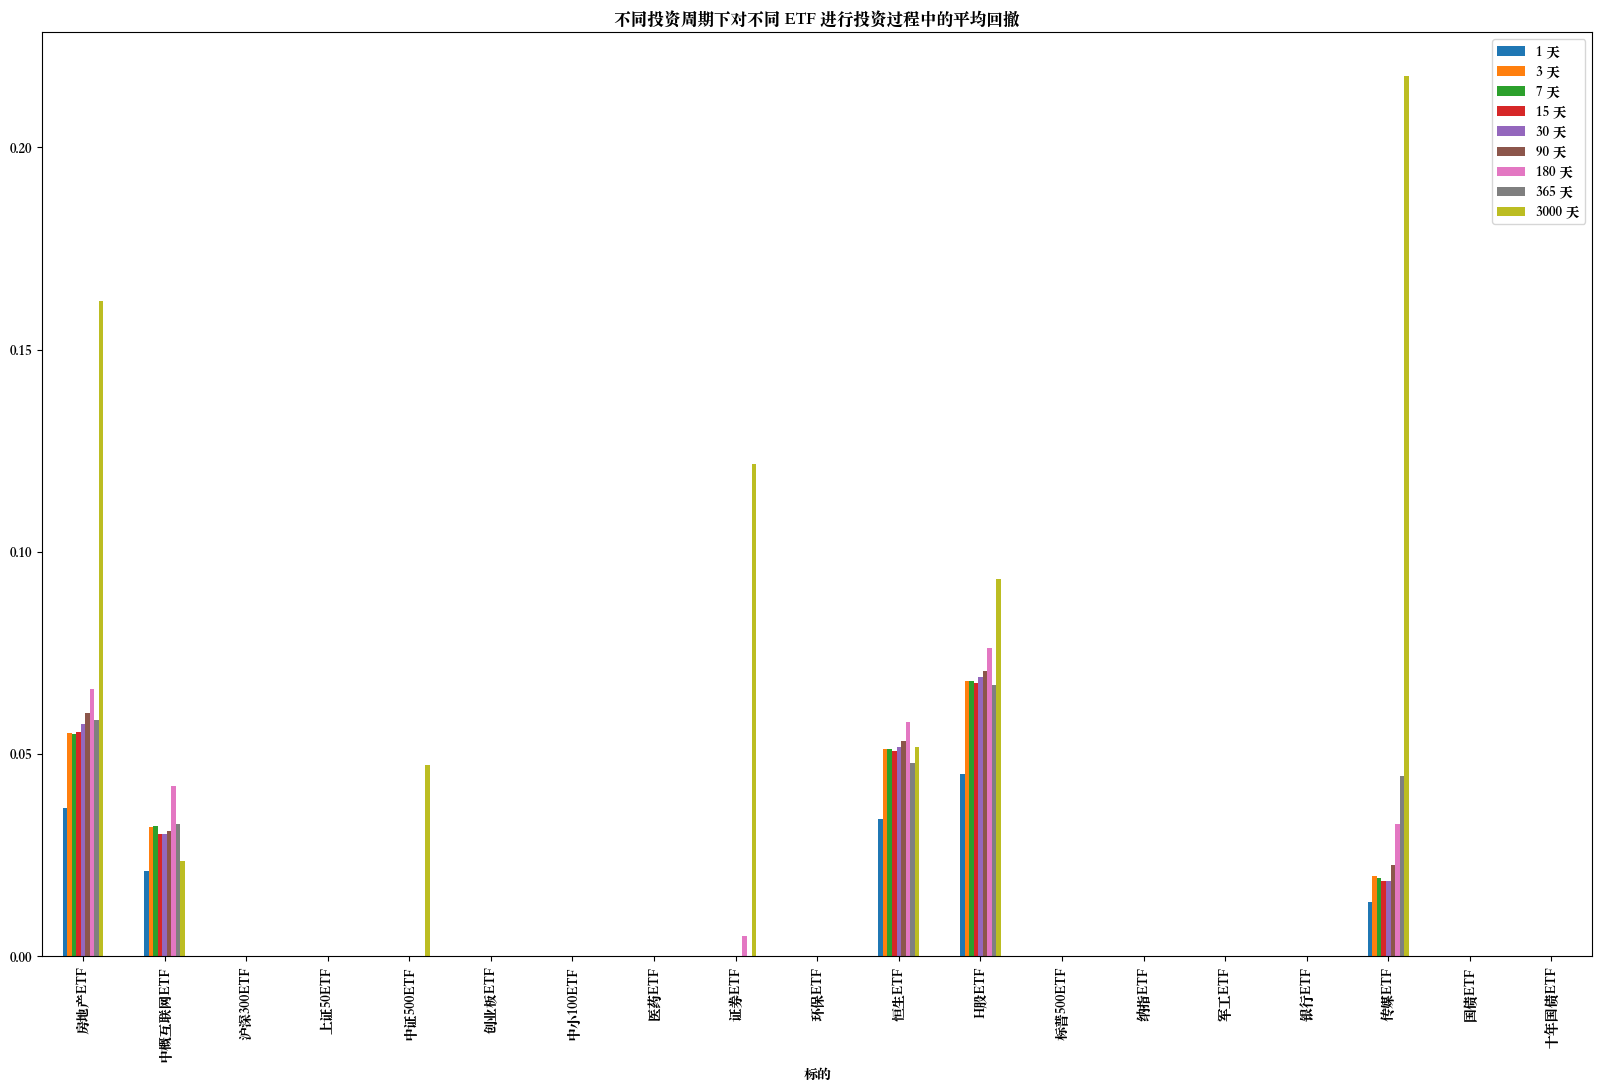

In [101]:
# 不同投资周期下使用每期五千元对不同标的进行投资过程中的平均回撤。
# 表格中高亮部分对应该标的的平均回撤的最大、最小值。

t = pd.concat(table3)
t.set_index('标的', inplace=True)
for row in t:
    t[row] = pd.to_numeric(t[row])
s = t.copy()
s[s < 0] = 0
s.plot(kind='bar', figsize=(20, 12),
       title='不同投资周期下对不同 ETF 进行投资过程中的平均回撤')
t.style.format(precision=3).highlight_min(axis='columns',
                                          color='lightgreen').highlight_max(axis='columns', color='lightcoral')

##### 静态投资组合

In [102]:
from math import floor


def calcProfolio(stockNameCode: tuple[str, str], step: datetime.timedelta, silent: bool = False) -> Result:
    '''
    Returns a tuple of (asset, ratio)
    '''
    PROFOLIO_RATIO_MIN = 0.6
    PROFOLIO_RATIO_EXP = 0.7
    PROFOLIO_RATIO_MAX = 0.8
    PROFOLIO_BASE = '511260'
    df = allStockDaily[stockNameCode[0]]

    # 开始时间
    START = max(df.iloc[0, 0], start)
    END = min(df.iloc[-1, 0], end)

    # 总期数
    PERIODS_TOTAL: int = (END-START)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = START
    # 初始资金：每期五千
    # 似乎有点少，但是这样可以更好地体现出投资的风险
    INIT = 5000 * PERIODS_TOTAL
    money = INIT
    # 基金数量（以 100 份为单位）
    stock_1 = 0
    stock_2 = 0
    extra = ExtraCost(silent=silent)

    min_asset = 1
    record_assets: list[float] = []

    if not silent:
        print(f"开始计算{stockNameCode[1]}")
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1
    for date, row in df.iterrows():
        # 日期
        date: pd.DatetimeIndex
        # 当日价格
        price_1: float = row[D]
        # print(allStockDaily[PROFOLIO_BASE].loc[:date])
        price_2: float = allStockDaily[PROFOLIO_BASE].iloc[-1, D]
        # 当前资产
        asset_now = (money+extra.sell(stock_1*100*price_1, store=False) +
                     extra.sell(stock_2*100*price_2, store=False))/INIT
        min_asset = min(min_asset, asset_now)
        record_assets.append(asset_now)
        l.append(pd.DataFrame([{'日期': date, '资产': asset_now}]))
        if cur <= date:
            # 本期准备使用的资金金额，大约每期 5000
            period_money = money/periods

            value_1_now = stock_1*100*price_1
            value_2_now = stock_2*100*price_2

            value_total_now = value_1_now+value_2_now
            EXPECT_VALUE_1 = (value_total_now+period_money) * \
                PROFOLIO_RATIO_EXP
            EXPECT_VALUE_2 = (value_total_now+period_money) * \
                (1-PROFOLIO_RATIO_EXP)

            if value_1_now/(value_total_now+period_money) > PROFOLIO_RATIO_MAX:
                # 如果 1 的价值占比超过最大比例，卖出 1
                stock_1_to_sell = floor(EXPECT_VALUE_1/price_1/100-stock_1)
                money += extra.sell(stock_1_to_sell*100*price_1, store=True)
                stock_1 -= stock_1_to_sell
                # 剩下的钱全用来买 2
                stock_2_to_buy = floor(period_money/price_2/100)
                money -= extra.buy(stock_2_to_buy*price_2*100, store=True)
                stock_2 += stock_2_to_buy
            elif (value_1_now+period_money)/(value_total_now+period_money) < PROFOLIO_RATIO_MIN:
                # 如果 1 的价值占比低于最小比例，卖出 2
                stock_2_to_sell = floor(EXPECT_VALUE_2/price_2/100-stock_2)
                money += extra.sell(stock_2_to_sell*100*price_2, store=True)
                stock_2 -= stock_2_to_sell
                # 剩下的钱全用来买 1
                stock_1_to_buy = floor(period_money/price_1/100)
                money -= extra.buy(stock_1_to_buy*price_1*100, store=True)
                stock_1 += stock_1_to_buy
            else:
                stock_1_to_buy = 0
                stock_2_to_buy = 0
                if value_1_now <= EXPECT_VALUE_1 and value_2_now <= EXPECT_VALUE_2:
                    stock_1_to_buy = EXPECT_VALUE_1//price_1//100-stock_1
                    stock_2_to_buy = EXPECT_VALUE_2//price_2//100-stock_2
                elif value_1_now <= EXPECT_VALUE_1:
                    stock_1_to_buy = period_money//price_1//100-stock_1
                elif value_2_now <= EXPECT_VALUE_2:
                    stock_2_to_buy = period_money//price_2//100-stock_2
                else:
                    assert False, "不可能出现的情况"
                if stock_1_to_buy >= 0:
                    stock_1 += stock_1_to_buy
                    value_stock_1_to_buy = stock_1_to_buy*100*price_1
                    money -= extra.buy(value_stock_1_to_buy, store=True)
                if stock_2_to_buy >= 0:
                    stock_2 += stock_2_to_buy
                    value_stock_2_to_buy = stock_2_to_buy*100*price_2
                    money -= extra.buy(value_stock_2_to_buy, store=True)
                assert money >= 0

            if not silent:
                STOCK_PRICE_1 = extra.sell(
                    stock_1*100*price_1, store=False)
                STOCK_PRICE_2 = extra.sell(stock_2*100*price_2, store=False)
                print(
                    f"第 {i} / {PERIODS_TOTAL} 期（{date}）: "
                    f"{money} + {STOCK_PRICE_1} + {STOCK_PRICE_2} = {round(money+STOCK_PRICE_1+STOCK_PRICE_2, 2)}")
            cur += step
            i += 1
            periods -= 1

    if not silent:
        ax = plt.axes(title=stockNameCode[1])
        # 当日与首日基金价格的比例
        normalized = df.iloc[:, D]/df.iloc[0, D]
        # 不太能理解的是这个地方为什么不能正常显示标签。
        normalized.plot(ax=ax, x='日期', y='开盘', label='当日开盘价与首日开盘价的比值')

        # 当日资金与投入资金的比例
        asset = pd.DataFrame(columns=['日期', '资产'])
        asset = pd.concat([asset, *l])
        asset.set_index('日期', drop=False, inplace=True)
        asset.plot(ax=ax, x='日期', y='资产', label='当日资产与初始资产的比值')
    price_1: float = df.iloc[-1, D]
    price_2: float = allStockDaily[PROFOLIO_BASE].iloc[-1, D]
    ratio_1: float = price_1/df.iloc[0, D]
    ratio_2: float = price_2/allStockDaily[PROFOLIO_BASE].iloc[0, D]
    final_1 = round(extra.sell(stock_1*100*price_1, store=True), 2)
    final_2 = round(extra.sell(stock_2*100*price_2, store=True), 2)
    asset_ratio = round(final_1+final_2+money, 2)/INIT
    max_drawdown = 1-min_asset
    avg_drawdown = 1-np.mean(record_assets)
    if not silent:
        print(f"剩余资金：{money}")
        print(f"股基数量：{stock_1*100}")
        print(f"债基数量：{stock_2*100}")
        print(f"股基单价：{price_1}")
        print(f"债基单价：{price_2}")
        print(f"股基比值（末日与首日）：{ratio_1}")
        print(f"债基比值（末日与首日）：{ratio_2}")
        print(f"基金名称：{stockNameCode[1]}")
        print(f"交易费用：{extra.get()}")
        print(f"最大回撤：{max_drawdown}")
        print(f"平均回撤；{avg_drawdown}")
        print(
            f"最终资产：{final_1} + {final_2} + {money} = {round(final_1+final_2+money,2)}")
        print(f"最终资产比值（末日与首日）：{asset_ratio}")
    return Result(asset_ratio, ratio_1, extra.get(), max_drawdown, avg_drawdown, PERIODS_TOTAL)

开始计算房地产ETF
总期数：27
开始时间：2017-09-25 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-25 00:00:00）: 131574.32 + 3414.14 + 0 = 134988.46
第 2 / 27 期（2017-12-25 00:00:00）: 129091.02 + 5902.12 + 0 = 134993.14
第 3 / 27 期（2018-03-26 00:00:00）: 127241.65000000001 + 7553.51 + 0 = 134795.16
第 4 / 27 期（2018-06-22 00:00:00）: 125623.23000000001 + 8567.76 + 0 = 134190.99
第 5 / 27 期（2018-09-20 00:00:00）: 124099.93000000001 + 9176.6 + 0 = 133276.53
第 6 / 27 期（2018-12-19 00:00:00）: 122851.98000000001 + 10080.28 + 0 = 132932.26
第 7 / 27 期（2019-03-19 00:00:00）: 122660.34000000001 + 13053.73 + 0 = 135714.07
第 8 / 27 期（2019-06-17 00:00:00）: 122052.52 + 12648.54 + 0 = 134701.06
第 9 / 27 期（2019-09-16 00:00:00）: 121440.5 + 13343.46 + 0 = 134783.96
第 10 / 27 期（2019-12-16 00:00:00）: 120817.98 + 14191.65 + 0 = 135009.63
第 11 / 27 期（2020-03-13 00:00:00）: 119961.81 + 14543.46 + 0 = 134505.27
第 12 / 27 期（2020-06-11 00:00:00）: 119038.13 + 15188.2 + 0 = 134226.33
第 13 / 27 期（2020-09-09 00:00:00）: 118748.07 + 17565.61 + 0 = 1363

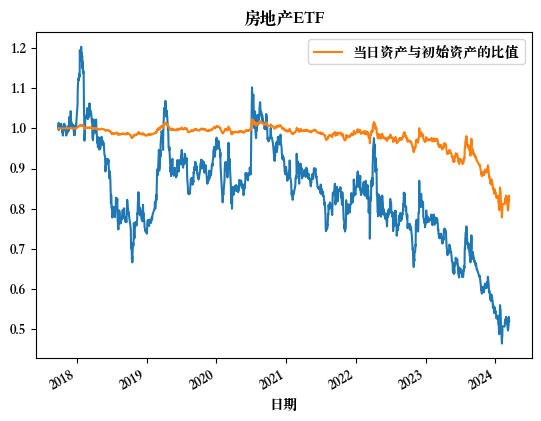

开始计算上证50ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 131579.92 + 3408.55 + 0 = 134988.47
第 2 / 27 期（2017-11-30 00:00:00）: 129295.26000000001 + 5854.33 + 0 = 135149.59
第 3 / 27 期（2018-02-28 00:00:00）: 127655.43000000001 + 7511.82 + 0 = 135167.25
第 4 / 27 期（2018-05-29 00:00:00）: 126123.62000000001 + 8541.26 + 0 = 134664.88
第 5 / 27 期（2018-08-27 00:00:00）: 124930.78000000001 + 9493.42 + 0 = 134424.2
第 6 / 27 期（2018-11-26 00:00:00）: 123786.35000000002 + 10245.24 + 0 = 134031.59
第 7 / 27 期（2019-02-25 00:00:00）: 123454.98000000003 + 12065.08 + 0 = 135520.06
第 8 / 27 期（2019-05-24 00:00:00）: 122822.25000000003 + 12230.14 + 0 = 135052.39
第 9 / 27 期（2019-08-22 00:00:00）: 122480.18000000002 + 13471.63 + 0 = 135951.81
第 10 / 27 期（2019-11-20 00:00:00）: 122129.11000000002 + 14177.45 + 0 = 136306.56
第 11 / 27 期（2020-02-18 00:00:00）: 121442.57000000002 + 14641.44 + 0 = 136084.01
第 12 / 27 期（2020-05-18 00:00:00）: 120439.27000000002 + 15295.37 + 0 = 135734.64
第 13 / 2

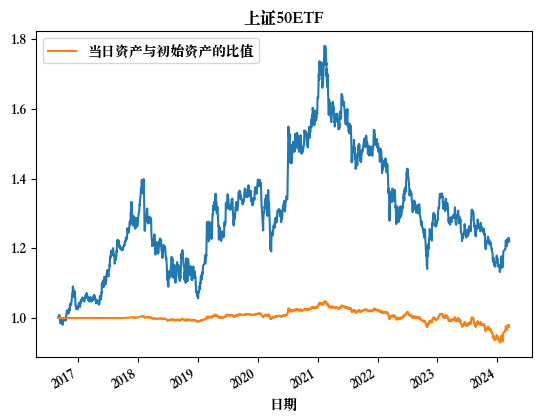

开始计算创业板ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 131619.93 + 3368.56 + 0 = 134988.49
第 2 / 27 期（2017-11-30 00:00:00）: 129119.93 + 5647.79 + 0 = 134767.72
第 3 / 27 期（2018-02-28 00:00:00）: 127298.46999999999 + 7422.64 + 0 = 134721.11
第 4 / 27 期（2018-05-29 00:00:00）: 125950.79999999999 + 8886.18 + 0 = 134836.98
第 5 / 27 期（2018-08-27 00:00:00）: 124519.51 + 8976.55 + 0 = 133496.06
第 6 / 27 期（2018-11-26 00:00:00）: 123021.40999999999 + 9322.67 + 0 = 132344.08
第 7 / 27 期（2019-02-25 00:00:00）: 122419.48999999999 + 11778.85 + 0 = 134198.34
第 8 / 27 期（2019-05-24 00:00:00）: 121445.49999999999 + 11894.42 + 0 = 133339.92
第 9 / 27 期（2019-08-22 00:00:00）: 121129.63999999998 + 13666.78 + 0 = 134796.42
第 10 / 27 期（2019-11-20 00:00:00）: 120793.56999999998 + 14886.28 + 0 = 135679.85
第 11 / 27 期（2020-02-18 00:00:00）: 120793.56999999998 + 18800.3 + 0 = 139593.87
第 12 / 27 期（2020-05-18 00:00:00）: 120793.56999999998 + 18341.41 + 0 = 139134.98
第 13 / 27 期（2020-08-17 00:00

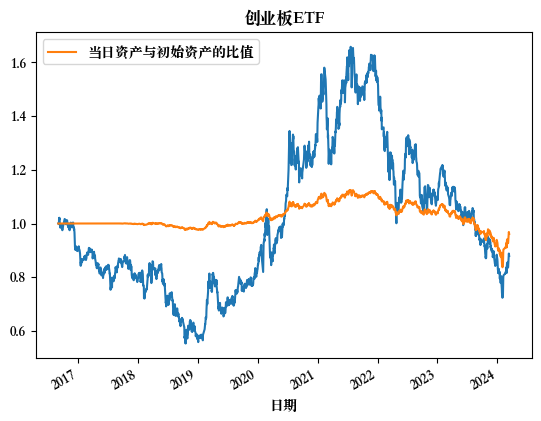

开始计算标普500ETF
总期数：27
开始时间：2017-09-01 00:00:00
初始资金：135000
第 1 / 27 期（2017-09-01 00:00:00）: 131535.11 + 3453.34 + 0 = 134988.45
第 2 / 27 期（2017-11-30 00:00:00）: 129126.62999999999 + 6081.08 + 0 = 135207.71
第 3 / 27 期（2018-02-28 00:00:00）: 127498.30999999998 + 7783.45 + 0 = 135281.76
第 4 / 27 期（2018-05-29 00:00:00）: 126198.64999999998 + 9053.53 + 0 = 135252.18
第 5 / 27 期（2018-08-27 00:00:00）: 125465.09999999998 + 10918.27 + 0 = 136383.37
第 6 / 27 期（2018-11-26 00:00:00）: 124608.42999999998 + 11061.73 + 0 = 135670.16
第 7 / 27 期（2019-02-25 00:00:00）: 123907.28999999998 + 11998.0 + 0 = 135905.29
第 8 / 27 期（2019-05-24 00:00:00）: 123357.97999999998 + 13052.53 + 0 = 136410.51
第 9 / 27 期（2019-08-22 00:00:00）: 123160.03999999998 + 14073.18 + 0 = 137233.22
第 10 / 27 期（2019-11-20 00:00:00）: 122949.69999999998 + 15183.4 + 0 = 138133.1
第 11 / 27 期（2020-02-18 00:00:00）: 122949.69999999998 + 16492.87 + 0 = 139442.57
第 12 / 27 期（2020-05-18 00:00:00）: 121976.50999999998 + 15285.58 + 0 = 137262.09
第 13 / 2

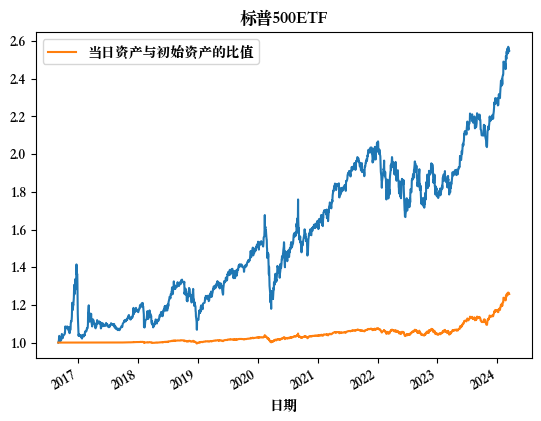

In [103]:
# 以房地产 ETF、上证 50 ETF、创业板 ETF、标普 500 ETF 为例
for i in [0, 3, 5, 12]:
    calcProfolio(stockNameCodes[i], datetime.timedelta(days=90))
    plt.show()

#### 动态投资组合

##### 基本框架

接下来的代码将根据一定策略计算并调整投资组合。

参考了 <https://zhuanlan.zhihu.com/p/60499205>。


In [104]:
from typing import Callable
from pypfopt import expected_returns, risk_models
from scipy.stats import normaltest
from typing import Any


# 由于上市较晚，除去房地产 ETF 和传媒 ETF
# 再去掉两只国债 ETF
stockNameCodesExcept = [(code, name)
                        for code, name in stockNameCodes if code not in ['512200', '512980', '511010', '511260']]
allStockDailyExcept = {code: stock for code,
                       stock in allStockDaily.items() if code not in ['512200', '512980', '511010', '511260']}


def calc_portfolio(step: datetime.timedelta, method: str, optimizer: Callable[[pd.DataFrame], np.ndarray], print_weight: bool = True, silent: bool = False) -> tuple[float, float, pd.DataFrame]:
    '''
    Returns a tuple of (asset, ratio)
    '''

    # 总期数
    PERIODS_TOTAL: int = (end-start)//step+1
    # 剩余期数
    periods = PERIODS_TOTAL
    # 开始时间
    cur: pd.DatetimeIndex = start
    # 初始资金：一百万
    INIT = 1000000
    money = INIT
    # 股票数量
    stocks = 0
    # 交易费用
    extra = ExtraCost(silent=silent)

    if not silent:
        print(f"总期数：{PERIODS_TOTAL}")
        print(f"开始时间：{cur}")
        print(f"初始资金：{money}")

    l = []

    i = 1

    # 持有量
    stocks = np.array([0 for _ in range(len(stockNameCodesExcept))])

    expectation: list[np.ndarray] = []
    track: list[pd.DataFrame] = []
    for date in pd.date_range(start=start, end=end, freq=step):
        # 各标的当日价格
        prices = [stock.loc[:date].iloc[:, D].to_numpy()
                  for _, stock in allStockDailyExcept.items()]
        # print(prices)
        prices = [p[-1] for p in prices]
        # print(prices)
        prices = np.array(prices)
        # print(prices,)

        df_prices = {}
        for code, stock in allStockDailyExcept.items():
            df_prices.setdefault(code, stock.loc[:date].iloc[:, D])
        df_prices = pd.DataFrame.from_dict(df_prices)
        # print(prices)

        log_returns = np.log(df_prices.pct_change()+1)
        ex = optimizer(log_returns)
        expectation.append(ex)

        # print(stocks)
        # print(prices)
        # print(money)
        asset: float = stocks.dot(prices)+money
        # 预期的投资组合比例
        weight: np.ndarray = ex
        # 预期的份数，未取整
        expected_stocks = weight*asset/prices
        # expected_stocks_rounded = np.round(expected_stocks, -2)
        expected_stocks_rounded = np.trunc(expected_stocks/100)*100
        # 实际的投资组合比例
        actual = stocks*prices/asset
        diff_stocks = expected_stocks_rounded-stocks
        # print(diff_stocks)
        diff = [*enumerate(diff_stocks)]
        diff.sort(key=lambda x: x[1], reverse=False)
        for i, diff_stock in diff:
            # 买入或卖出股票
            # 先卖出再买入
            if diff_stock > 0:
                # 买入
                while money < extra.buy(diff_stock*prices[i], store=False):
                    if not silent:
                        print(
                            f"剩余资金 {money} 不足以购买 {diff_stock} 份 {stockNameCodesExcept[i][1]}")
                    diff_stock -= 100
                money -= extra.buy(diff_stock*prices[i], store=True)
                stocks[i] += diff_stock
            elif diff_stock < 0:
                # 卖出
                money += extra.sell(-diff_stock*prices[i], store=True)
                stocks[i] += diff_stock
            assert money >= 0
            assert not stocks[stocks < 0].any(), f"股票数量 {stocks} 不能为负"

        d: dict[str, Any] = {name: [extra.sell(stock*prices[i], store=False)] for i, ((code, name), stock) in enumerate(zip(
            stockNameCodesExcept, stocks))}
        d.setdefault('日期', [date])
        d.setdefault('流动资金', [money])
        track.append(pd.DataFrame(d))
        # print(lower_bounds, upper_bounds, weight)

        # plt.plot(log_returns)
        # log_returns = log_returns.dropna()
        # log_returns.mean()*252
        if False:
            verification = []
            for code, name in stockNameCodes:
                if code == '512200':  # 房地产ETF
                    continue
                # print('\nResults for {}'.format(name))
                # print('-'*32)
                log_data = np.array(log_returns[code])
                log_data = log_data[~np.isnan(log_data)]    # 去除 NaN
                normaltestresult = normaltest(log_data)
                verification.append(
                    pd.DataFrame.from_dict(
                        {
                            'name': [name],
                            'statistic': [normaltestresult[0]],
                            'pvalue': [normaltestresult[1]]
                        }
                    )
                )

            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
            # 不太符合正态分布
            verification = pd.concat(verification)
            verification.set_index('name', inplace=True)
            # verification.style.format(precision=3).highlight_max(axis='columns')
            print(verification)
            verification.plot(y='pvalue', kind='bar',
                              title='正态性检验结果', figsize=(20, 12), yticks=[i*0.01 for i in range(0, 30)])

        # 让我们看看历史平均收益率和历史协方差
        if False:
            mu = expected_returns.mean_historical_return(
                df_prices, compounding=True, log_returns=True)
            S = risk_models.sample_cov(df_prices, log_returns=True)
            # print(date, mu, S, sep='\n')

    # 各标的当日价格
    prices = [stock.loc[:end].iloc[:, D].to_numpy()
              for _, stock in allStockDailyExcept.items()]
    # print(prices)
    prices = np.array([p[-1] for p in prices])

    d: dict[str, Any] = {name: [extra.sell(stock*prices[i], store=False)] for i, ((code, name), stock) in enumerate(zip(
        stockNameCodesExcept, stocks))}
    d.setdefault('日期', [end])
    d.setdefault('流动资金', [money])
    track.append(pd.DataFrame(d))

    t = pd.concat(track)
    t.set_index('日期', drop=True, inplace=True)
    if not silent:
        t.plot(  # x='日期',  y=[name for _, name in stockNameCodesExcept]+['流动资金'],
            title=f'{step.days} 天投资周期下投资组合的调整', figsize=(20, 12))

    if not silent and print_weight:
        # 最优投资组合
        weights: pd.DataFrame = pd.DataFrame(expectation,
                                             columns=[name for _, name in stockNameCodesExcept])
        weights.loc[:, '日期'] = pd.date_range(start=start, end=end, freq=step)
        weights.set_index('日期', drop=True, inplace=True)
        # print(weights.round(3))
        weights.plot(figsize=(20, 12),
                     title=f'{step.days} 天投资周期下基于{method}的最优投资组合（权重）')

    final = round(sum([extra.sell(price*stocks[i], store=True)
                  for i, price in enumerate(prices)]), 2)
    asset_ratio = round(final+money, 2)/INIT

    if not silent:
        print(f"剩余资金：{money}")
        print(f"持有量：{stocks}")
        print(f"交易费用：{extra.get()}")
        print(f"最终资产：{final} + {money} = {round(final+money,2)}")
        print(f"最终资产与投入资金的比值：{asset_ratio}")
        print(f"日化收益率：{(asset_ratio**(1/(end-start).days)-1)*100:.2f}%")
        print(f"年化收益率：{(asset_ratio**(1/(end-start).days*365)-1)*100:.2f}%")
    return asset_ratio,  extra.get(), t

##### 随机的固定投资组合

首先我们测试一下随机选取三只 ETF 后确定随机的固定组合比例的效果。


第 1 次随机权重，选取 5 个标的。
                 0
标普500ETF  0.215678
军工ETF     0.033209
上证50ETF   0.281474
中证500ETF  0.282596
恒生ETF     0.187043
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：451.9300000001267
持有量：[     0      0 103400 185700      0      0      0      0      0 199800
      0  69700      0  42800      0]
交易费用：3314.17
最终资产：1151570.4 + 451.9300000001267 = 1152022.33
最终资产与投入资金的比值：1.15202233
日化收益率：0.01%
年化收益率：2.19%


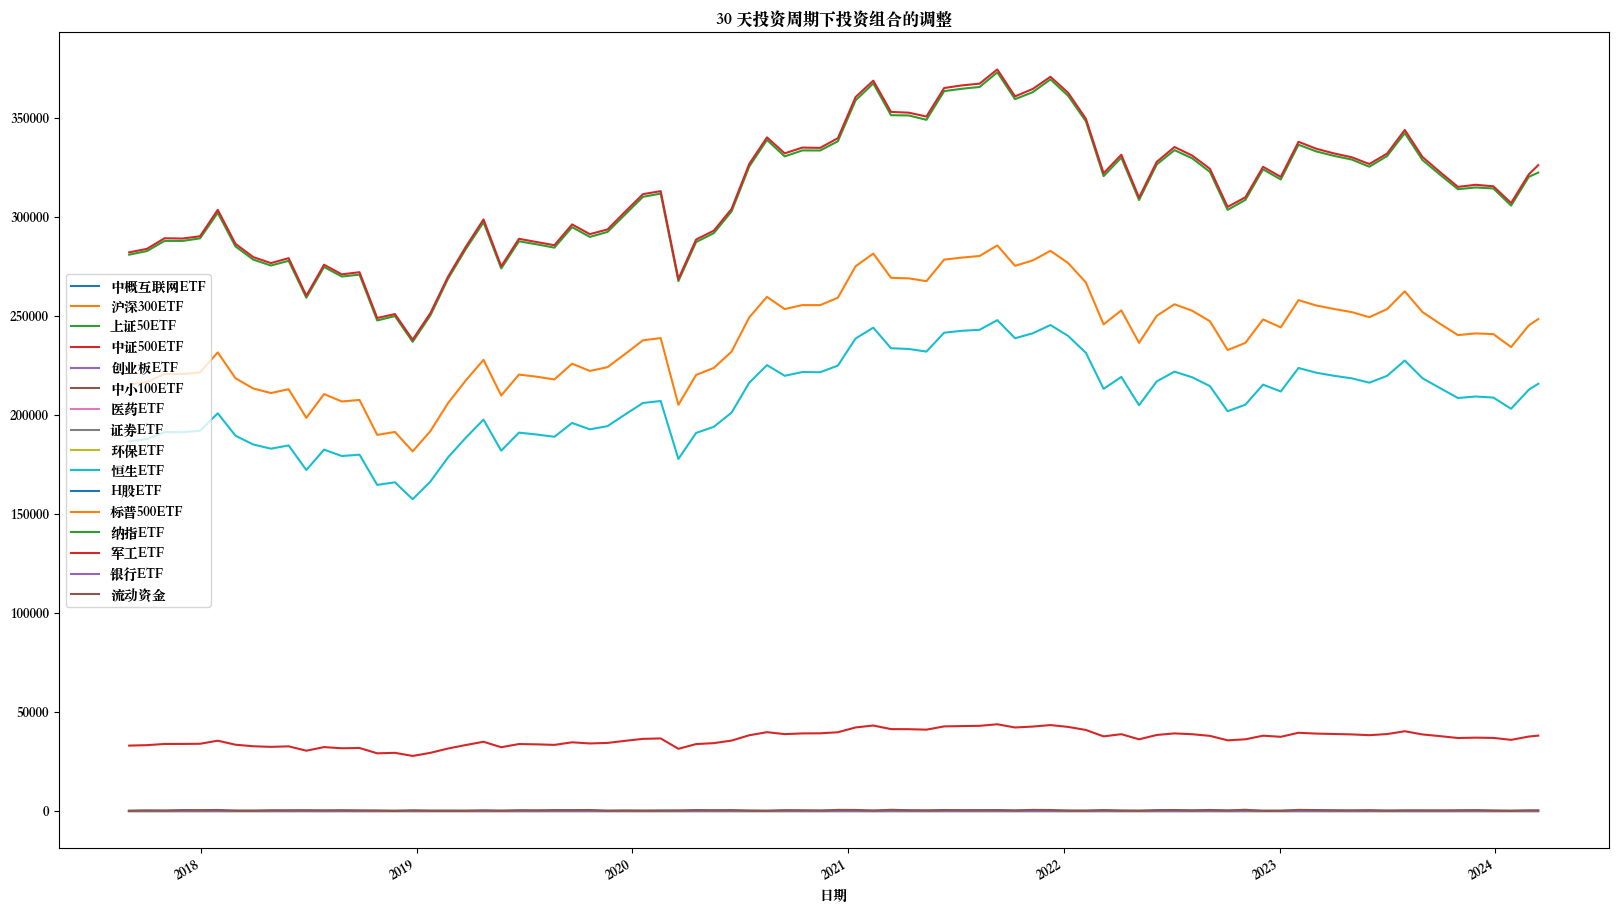

第 2 次随机权重，选取 5 个标的。
                 0
创业板ETF    0.263202
中证500ETF  0.153692
证券ETF     0.026528
上证50ETF   0.317174
H股ETF     0.239405
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：357.3100000000113
持有量：[     0      0  93000  80600 137100      0      0  26500      0      0
 281600      0      0      0      0]
交易费用：3215.9700000000003
最终资产：928508.72 + 357.3100000000113 = 928866.03
最终资产与投入资金的比值：0.92886603
日化收益率：-0.00%
年化收益率：-1.12%


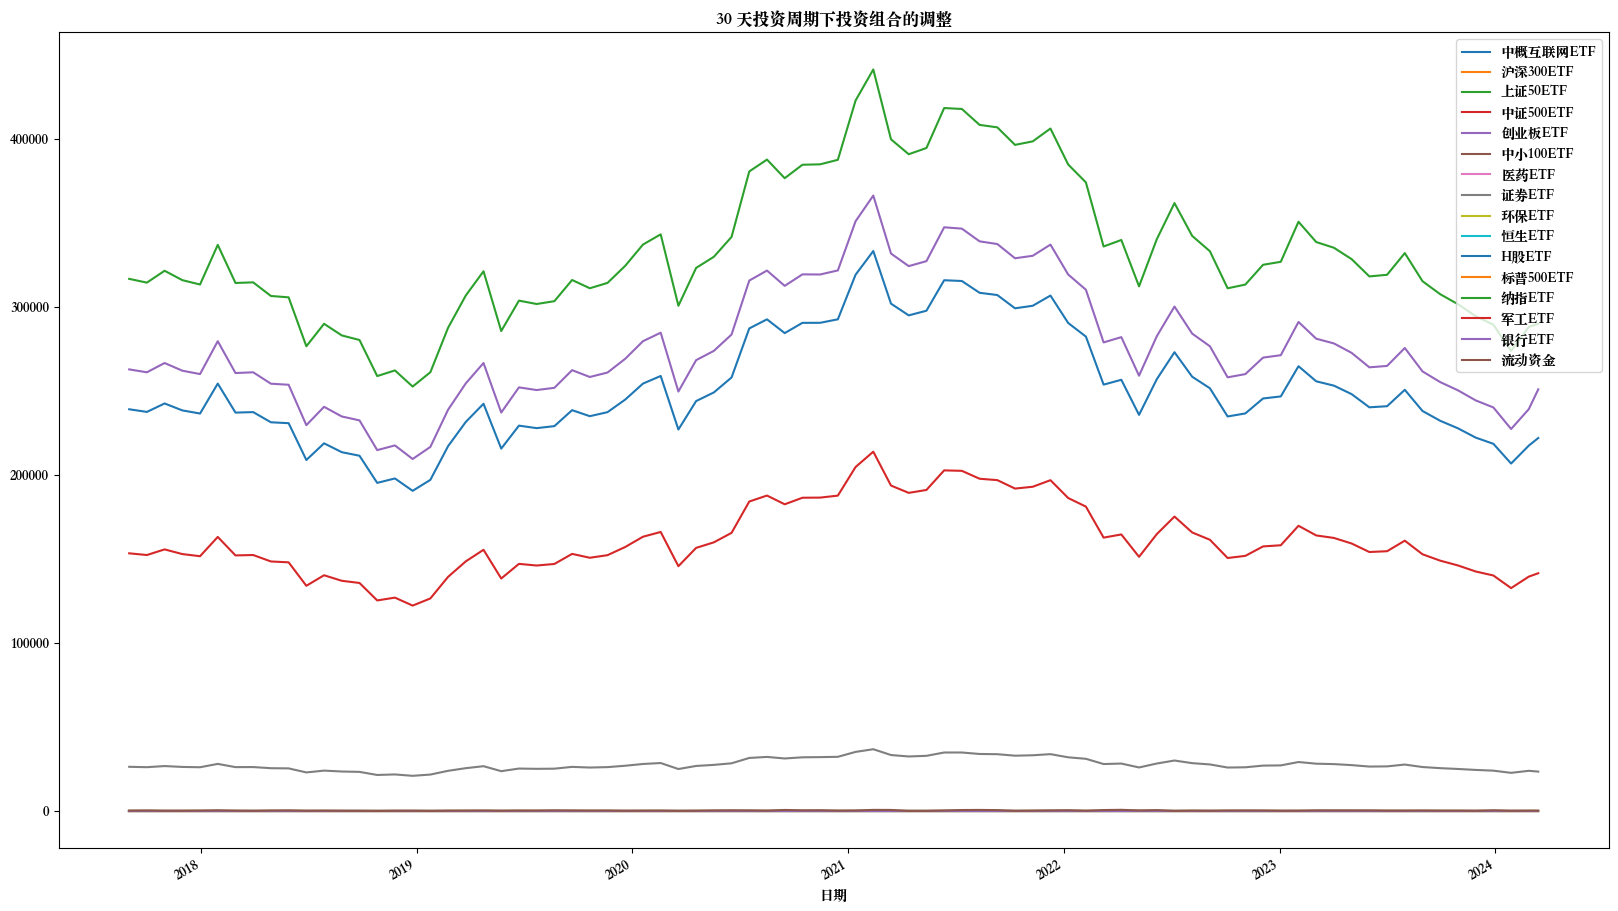

第 3 次随机权重，选取 5 个标的。
                 0
沪深300ETF  0.191354
纳指ETF     0.282770
创业板ETF    0.335080
银行ETF     0.080081
中证500ETF  0.110715
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：844.4600000001185
持有量：[     0  67300      0  93300 280400      0      0      0      0      0
      0      0  63200      0 100700]
交易费用：3759.4600000000005
最终资产：1494527.98 + 844.4600000001185 = 1495372.44
最终资产与投入资金的比值：1.49537244
日化收益率：0.02%
年化收益率：6.35%


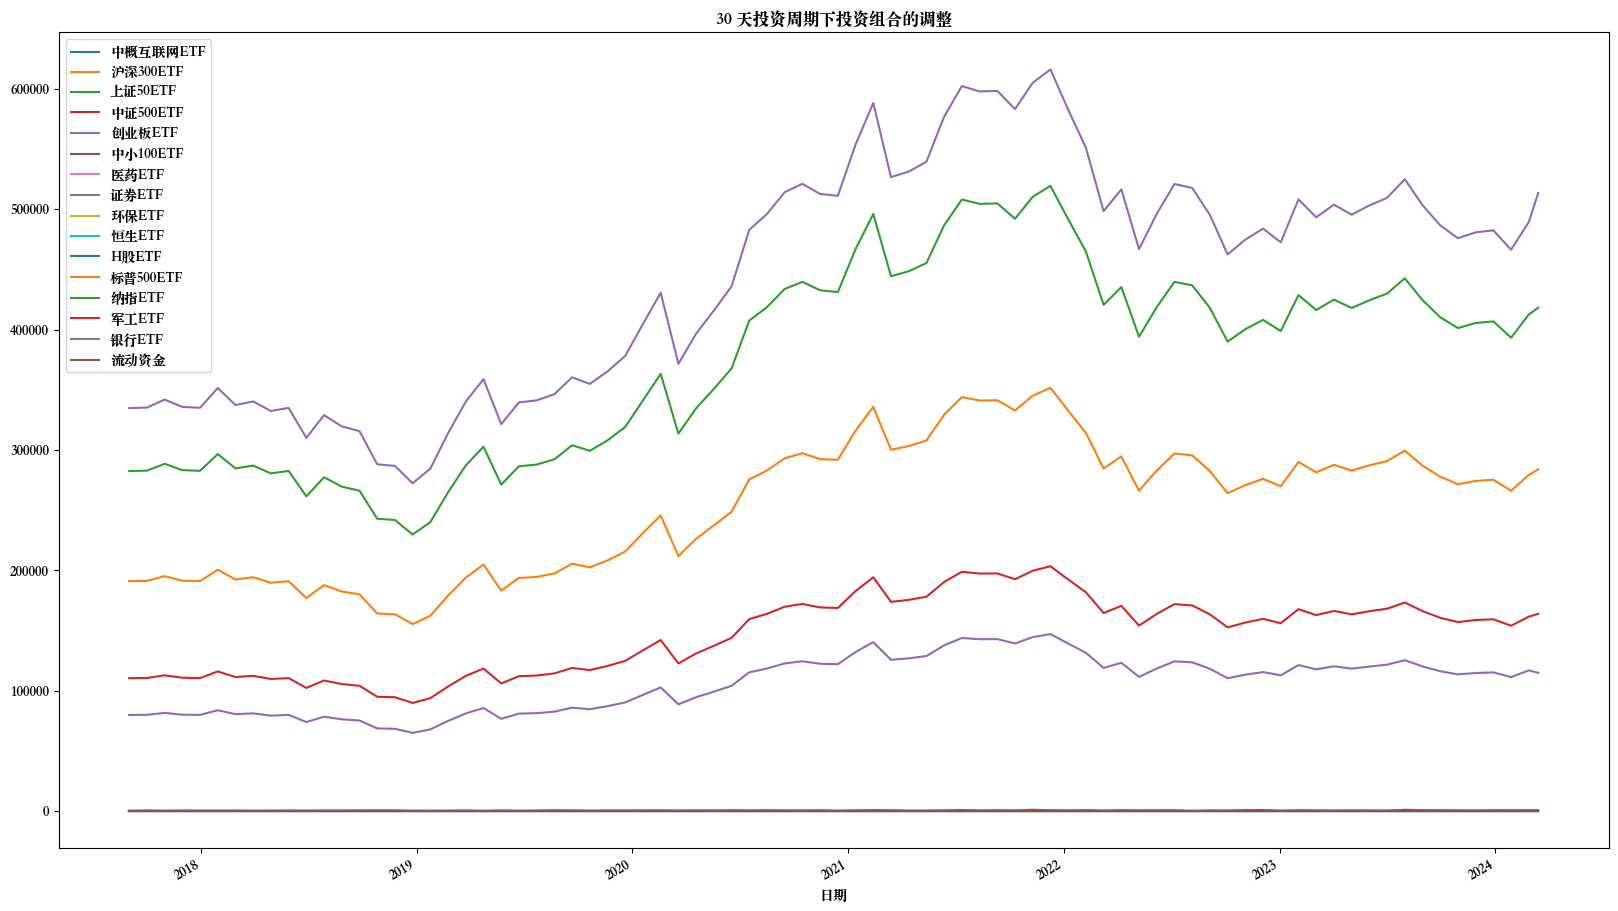

第 4 次随机权重，选取 5 个标的。
                 0
中证500ETF  0.202995
中小100ETF  0.139192
创业板ETF    0.057921
H股ETF     0.437299
证券ETF     0.162592
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金 437245.53 不足以购买 361100.0 份 H股ETF
剩余资金 437245.53 不足以购买 361000.0 份 H股ETF
剩余资金：445.7200000000462
持有量：[     0      0      0  92200  26100  35900      0 140800      0      0
 445500      0      0      0      0]
交易费用：3109.040000000001
最终资产：798196.64 + 445.7200000000462 = 798642.36
最终资产与投入资金的比值：0.79864236
日化收益率：-0.01%
年化收益率：-3.38%


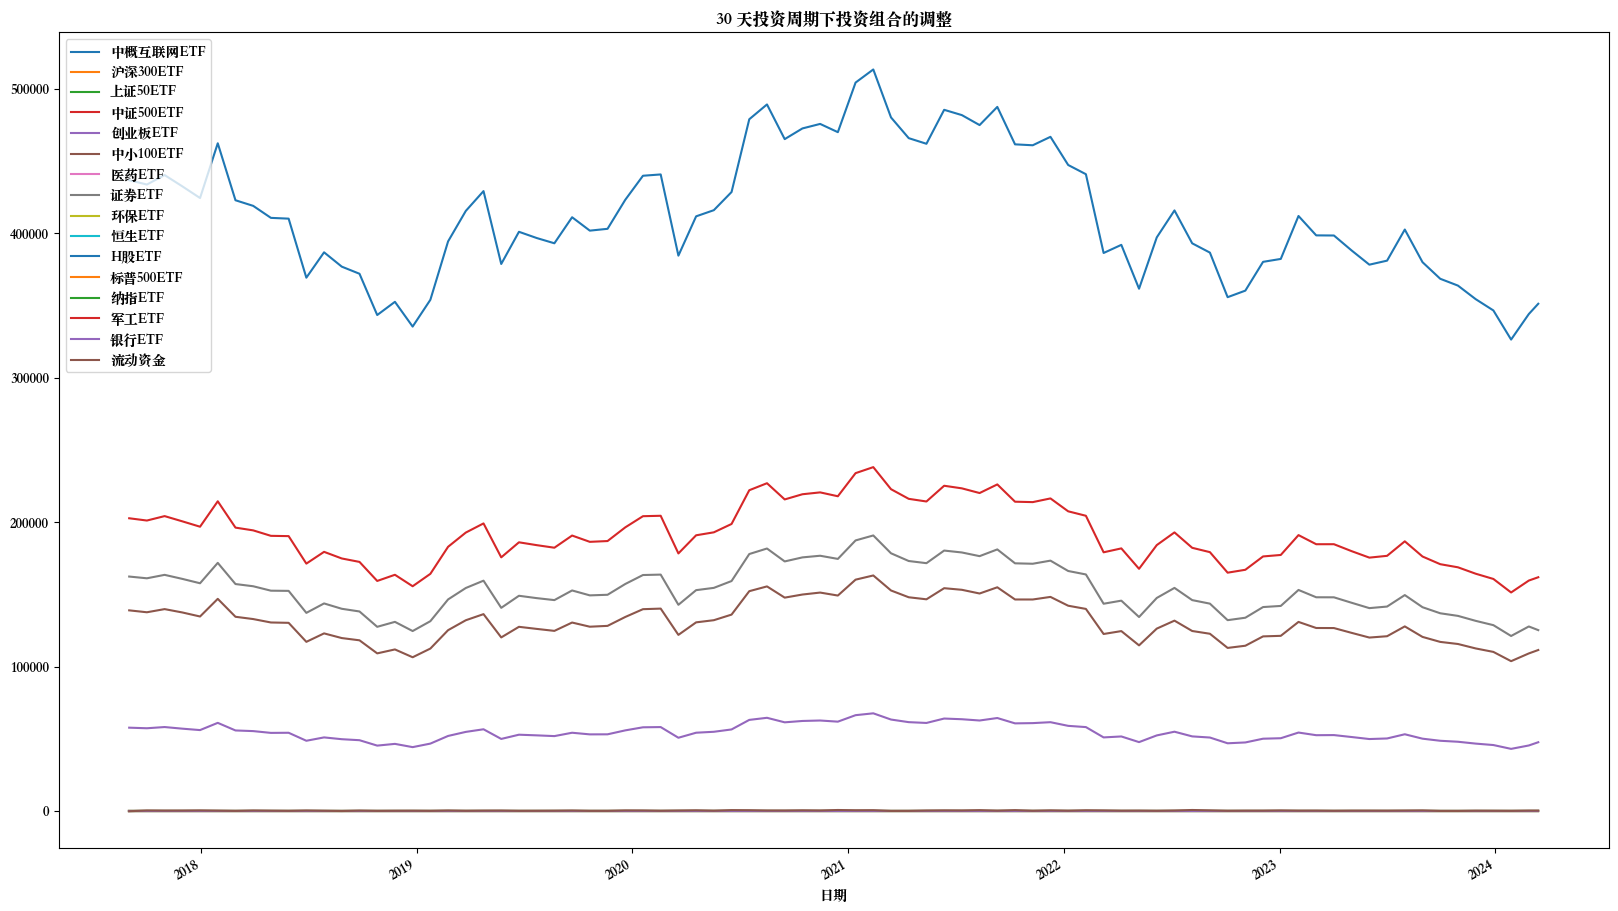

第 5 次随机权重，选取 5 个标的。
                 0
上证50ETF   0.194232
创业板ETF    0.486082
中概互联网ETF  0.089844
恒生ETF     0.155809
军工ETF     0.074032
总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金：349.1500000000158
持有量：[ 94200      0  59500      0 264600      0      0      0      0 138900
      0      0      0  79700      0]
交易费用：3343.7400000000016
最终资产：978389.61 + 349.1500000000158 = 978738.76
最终资产与投入资金的比值：0.97873876
日化收益率：-0.00%
年化收益率：-0.33%


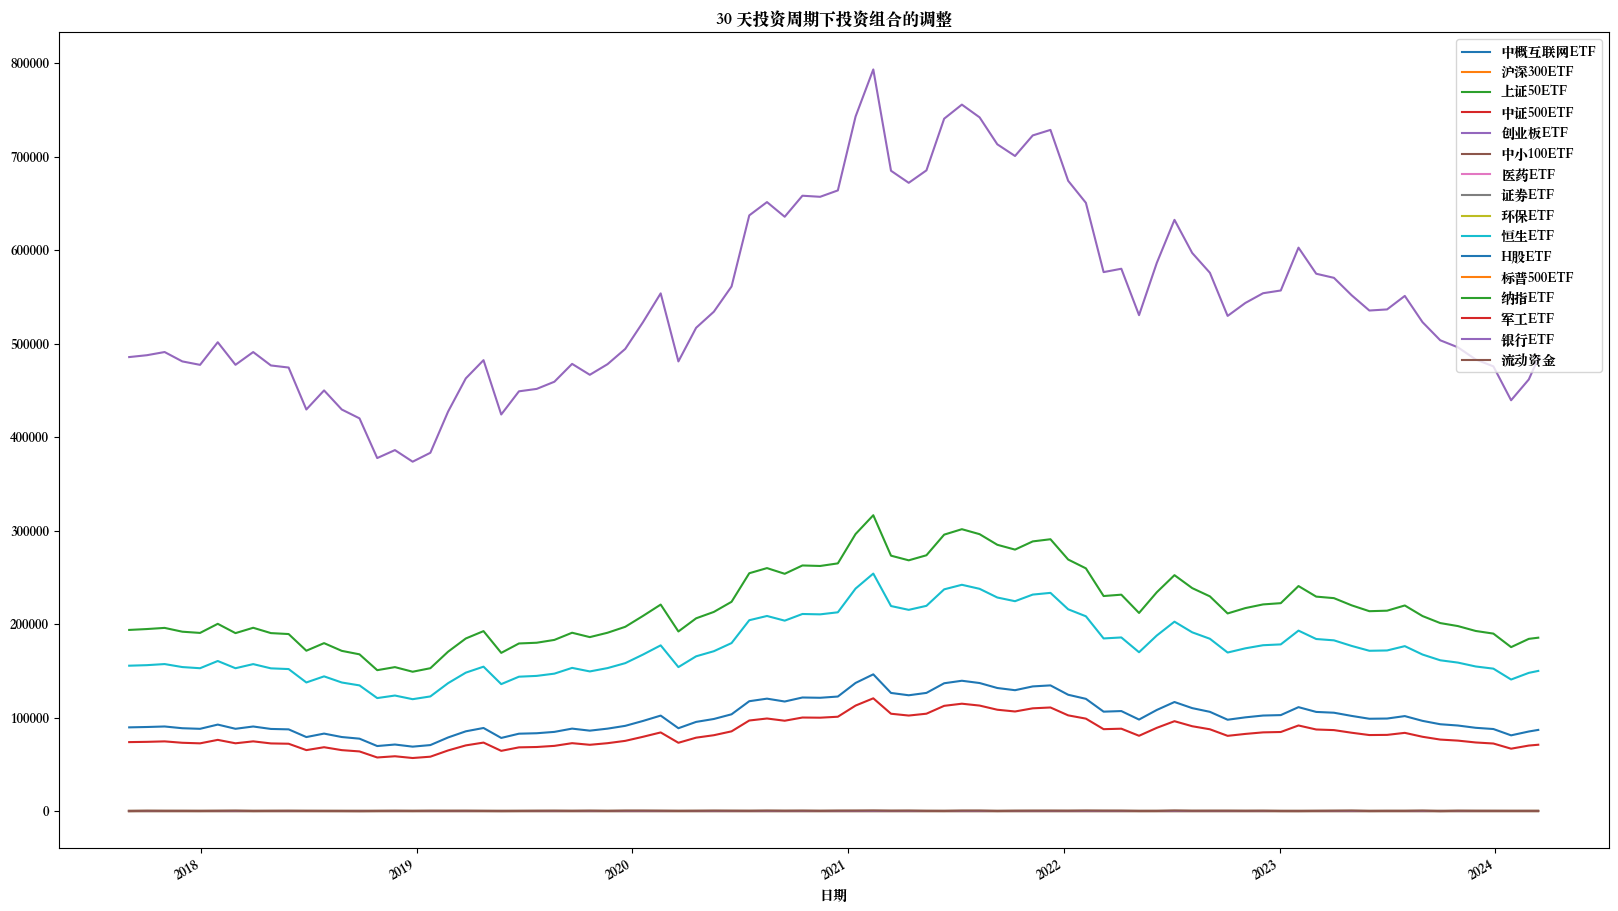

In [105]:
for i in range(5):
    N = 5
    print(f"第 {i+1} 次随机权重，选取 {N} 个标的。")
    w = np.random.choice(len(stockNameCodesExcept), N, replace=False)
    random = np.random.rand(N)
    random /= np.sum(random)

    random_weights = np.zeros(len(stockNameCodesExcept))
    for i, r in zip(w, random):
        random_weights[i] = r

    print(pd.DataFrame([random], columns=[
        stockNameCodesExcept[name][1] for name in w]).T)

    calc_portfolio(datetime.timedelta(days=30),
                   '随机固定权重', lambda _: random_weights, print_weight=False)
    plt.show()

##### 最大化夏普指数

夏普指数是投资组合的预期回报与投资组合风险之间的平衡。

夏普指数越高，投资组合的风险越低，回报越高。

夏普指数的计算公式为：$\mathrm{Sharpe} = \frac{R_p - R_f}{\sigma_p}$。
其中 $R_p$ 是投资组合的预期回报，$R_f$ 是无风险利率，$\sigma_p$ 是投资组合的标准差。

此处将无风险利率设为 0。


In [106]:
def minimal_sharpley(log_returns: pd.DataFrame) -> np.ndarray:
    '''
    为了最大化夏普指数，我们需要找到一个权重向量，使得夏普指数最大化。
    最小化夏普指数的负值。
    '''
    from scipy.optimize import minimize
    # print(log_returns.shape)

    def stats(weights):
        weights = np.array(weights)
        port_returns = np.sum(log_returns.mean()*weights)*252
        port_variance = np.sqrt(
            np.dot(weights.T, np.dot(log_returns.cov()*252, weights)))
        return np.array([port_returns, port_variance, port_returns/port_variance])

    # 最小化夏普指数的负值
    def min_sharpe(weights: np.ndarray) -> float:
        # print(weights.shape)
        return -stats(weights)[2]

    # ETF 数量
    N = log_returns.shape[1]
    # 给定初始权重
    x0 = N*[1./N]

    # 权重（某股票持仓比例）限制在 0 和 1 之间。
    bnds = tuple((0, 1) for _ in range(N))

    # 权重（股票持仓比例）的总和为 1。
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

    # 优化函数调用中忽略的唯一输入是起始参数列表(对权重的初始猜测)。我们简单的使用平均分布。
    opts = minimize(min_sharpe,
                    x0,
                    method='SLSQP',
                    bounds=bnds,
                    constraints=cons)
    assert opts.success, f"优化失败。{opts.message}"
    return opts.x

总期数：80
开始时间：2017-09-01 00:00:00
初始资金：1000000
剩余资金 195811.34999999992 不足以购买 73100.0 份 纳指ETF
剩余资金 130039.33999999991 不足以购买 85200.0 份 医药ETF
剩余资金 183835.7699999999 不足以购买 130000.0 份 恒生ETF
剩余资金 194733.1399999999 不足以购买 42100.0 份 纳指ETF
剩余资金：118.45999999990454
持有量：[     0      0      0      0      0      0      0      0      0      0
      0  57500 256300      0      0]
交易费用：8270.349999999999
最终资产：1901048.19 + 118.45999999990454 = 1901166.65
最终资产与投入资金的比值：1.90116665
日化收益率：0.03%
年化收益率：10.33%


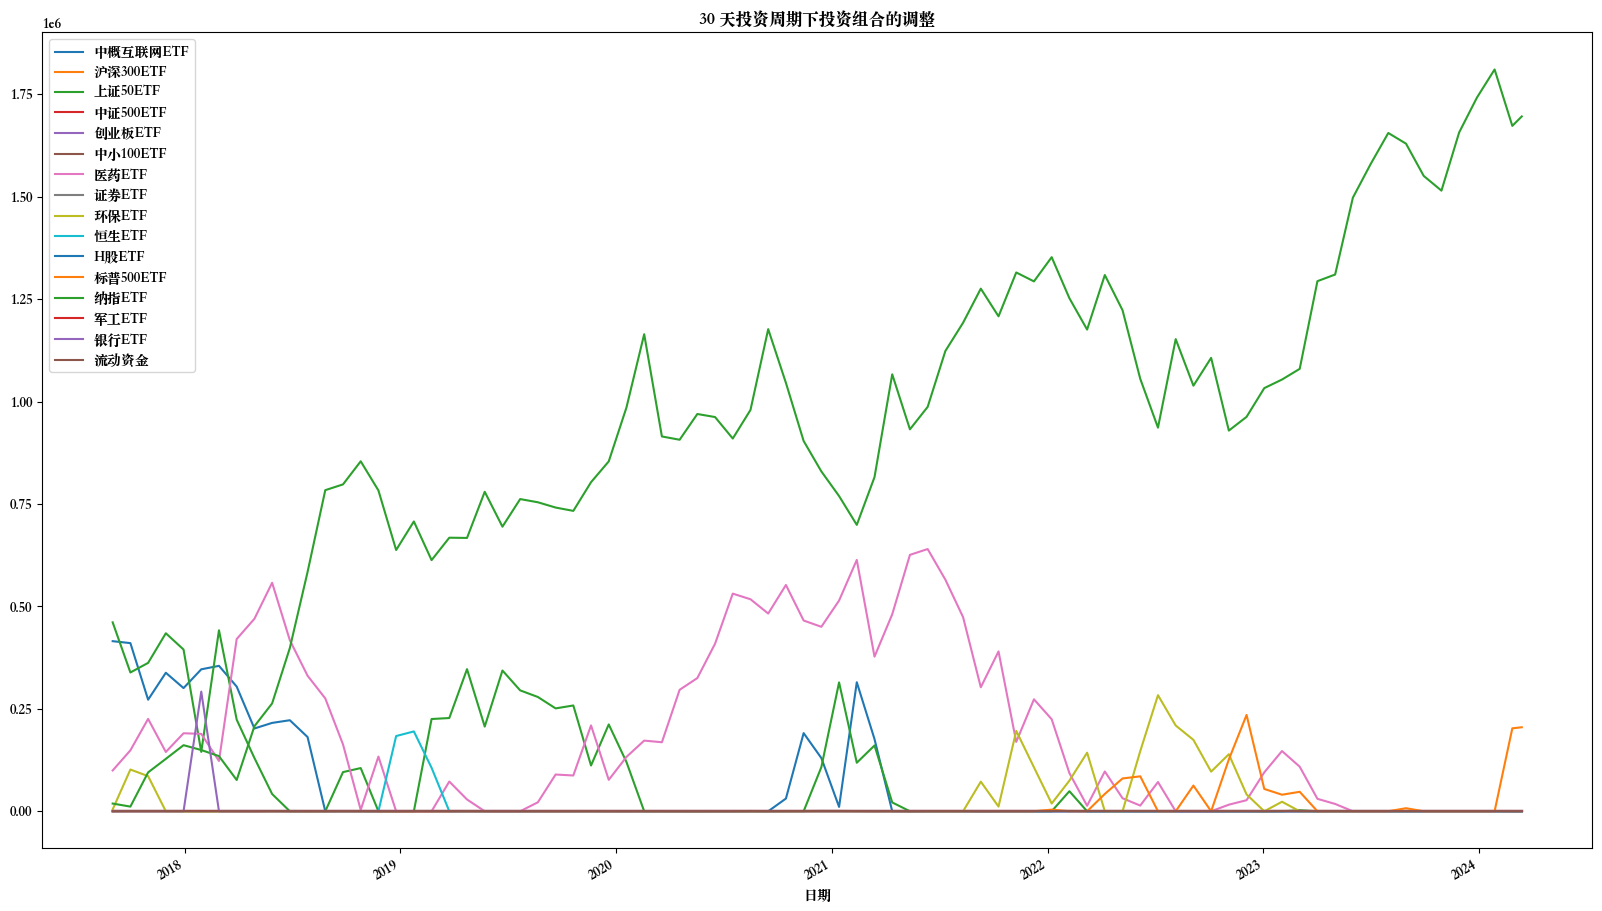

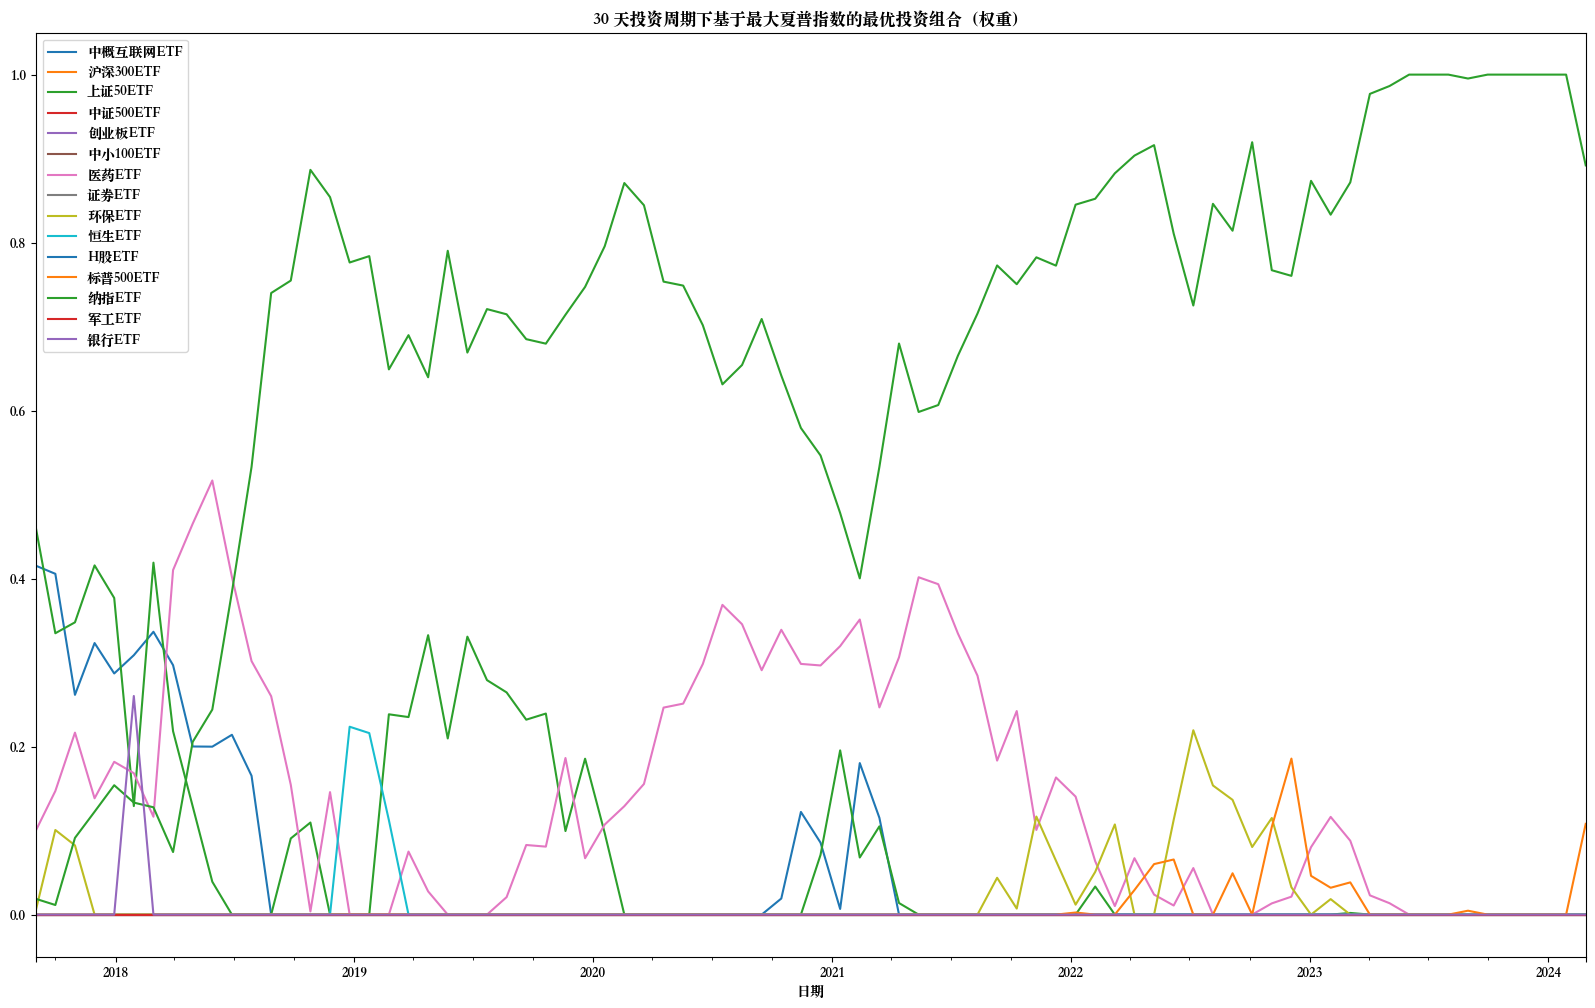

In [107]:
calc_portfolio(datetime.timedelta(days=30), '最大夏普指数', minimal_sharpley)
plt.show()

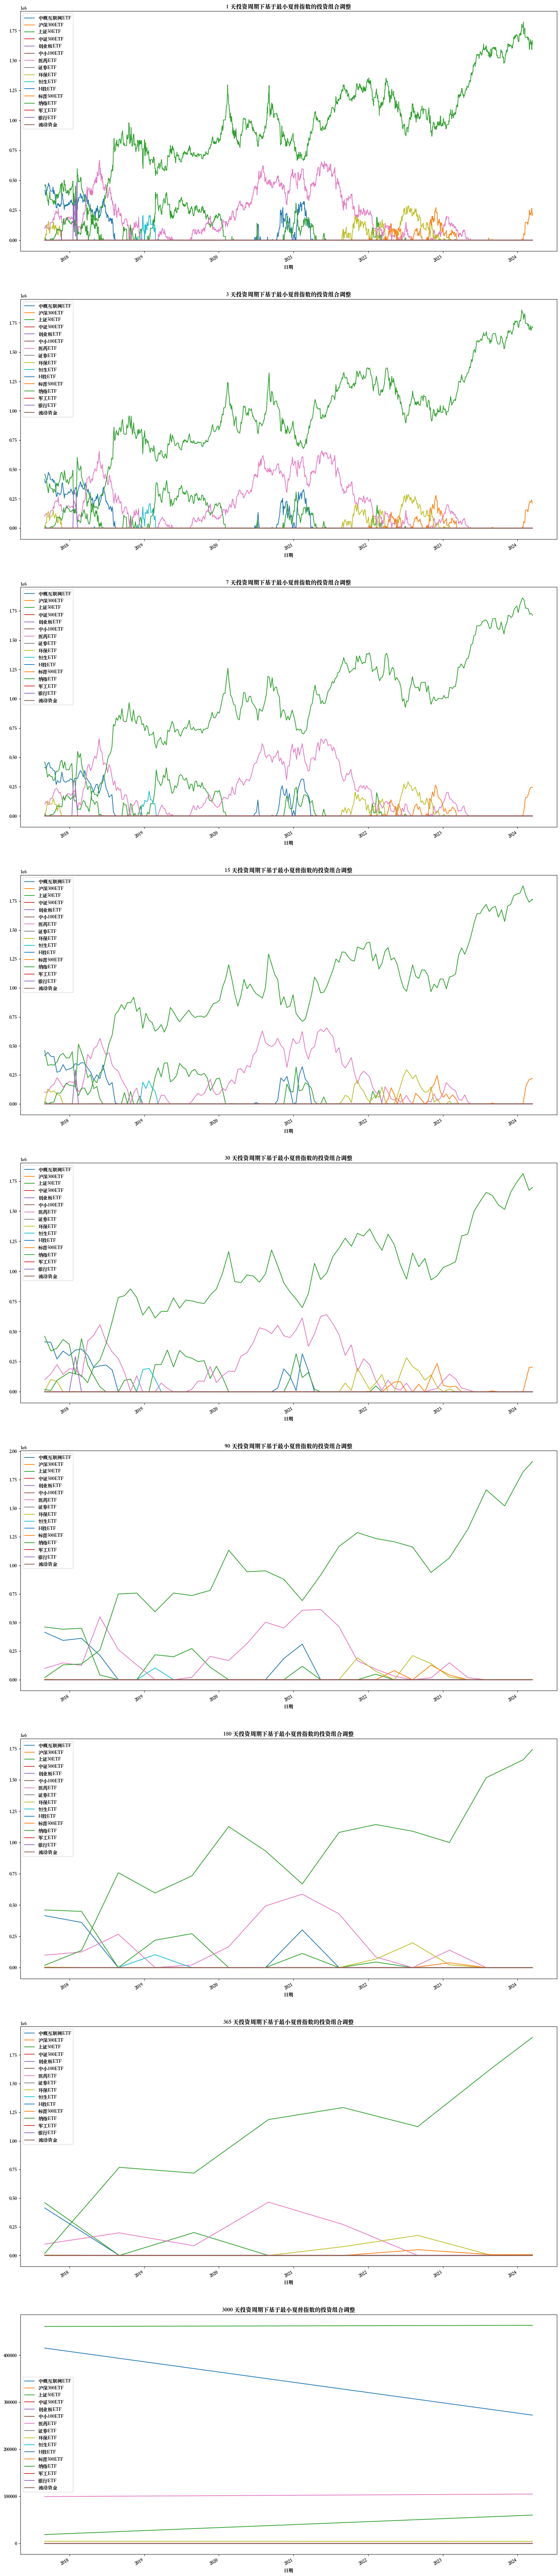

投资回报比      交易费用
投资周期                         
1 days     1.866888  41296.75
3 days     1.925302  24550.60
7 days     1.956336  15366.55
15 days    1.976236  11293.83
30 days    1.901167   8270.35
90 days    1.909124   4825.84
180 days   1.742997   3810.86
365 days   1.912801   2733.80
3000 days  0.905710    779.48

In [108]:
from joblib import Parallel, delayed

fig = plt.figure(1, figsize=(20, 12*len(deltas)))
axes = fig.subplots(len(deltas), 1)
# axes = [fig.add_subplot(len(deltas), 1, i+1) for i in range(len(deltas))]


def to_df(i: int, step: datetime.timedelta) -> tuple[pd.DataFrame, pd.DataFrame]:
    final, extra, b = calc_portfolio(
        step, '最大夏普指数', minimal_sharpley, silent=True)
    a = pd.DataFrame({"投资周期": [step], "投资回报比": [final], "交易费用": [extra]})
    return a, b


res: list[tuple[pd.DataFrame, pd.DataFrame]]
# res = [to_df(i, delta) for i, delta in enumerate(deltas[-1:])]
res = Parallel(n_jobs=-1)(delayed(to_df)(i, delta)
                          for i, delta in enumerate(deltas))

a, b = zip(*res)
for i, b in enumerate(b):
    b.plot(ax=axes[i], title=f'{deltas[i].days} 天投资周期下基于最小夏普指数的投资组合调整')
plt.show()
t = pd.concat(a)
t.set_index('投资周期', inplace=True)
t

##### PyPortfolioOpt 库的使用


In [109]:
# 使用前几年的股价数据来决定投资组合并不会有太大的意义（之后腾飞的两只 ETF 在此时都平平无奇），
# 但是可以用来展示如何使用 PyPortfolioOpt 这个库。
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# https://pyportfolioopt.readthedocs.io/en/latest/

pre = datetime.datetime(2015, 9, 1)
allStockDailyPre = Preprocess(pre, start)

stockNameCodesPre = stockNameCodes.copy()
# 房地产 ETF 尚未上市
stockNameCodesPre.remove(("512200", "房地产ETF"))
stockNameCodesPre.remove(("512980", "传媒ETF"))
# 与前面的 prices 相似，但没有除以首日的价格
df = pd.concat([i.iloc[:, 2]for _, i in allStockDailyPre.items()],
               keys=[i[1] for i in stockNameCodesPre], axis=1)
# df = pd.read_csv("../PyPortfolioOpt/tests/resources/stock_prices.csv",
#                  parse_dates=True, index_col="date")

# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
w = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

print(ef.clean_weights())

使用已有数据(2014-2017)
房地产ETF(512200)读取失败!
传媒ETF(512980)读取失败!
Expected annual return: 26.6%
Annual volatility: 5.3%
Sharpe Ratio: 4.68
OrderedDict([('中概互联网ETF', 0.18051), ('沪深300ETF', 0.0), ('上证50ETF', 0.0), ('中证500ETF', 0.0), ('创业板ETF', 0.0), ('中小100ETF', 0.0), ('医药ETF', 0.00623), ('证券ETF', 0.0), ('环保ETF', 0.0), ('恒生ETF', 0.0), ('H股ETF', 0.0), ('标普500ETF', 0.0), ('纳指ETF', 0.0), ('军工ETF', 0.0), ('银行ETF', 0.0), ('国债ETF', 0.18784), ('十年国债ETF', 0.62542)])


/opt/homebrew/anaconda3/lib/python3.11/site-packages/pypfopt/risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


In [110]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
da = DiscreteAllocation(w, latest_prices, total_portfolio_value=20000)
allocation, leftover = da.lp_portfolio(reinvest=True, verbose=True)
print(allocation)

Funds remaining: 19.73
中概互联网ETF: allocated 0.181, desired 0.181
沪深300ETF: allocated 0.001, desired 0.000
上证50ETF: allocated 0.000, desired 0.000
中证500ETF: allocated 0.000, desired 0.000
创业板ETF: allocated 0.000, desired 0.000
中小100ETF: allocated 0.001, desired 0.000
医药ETF: allocated 0.007, desired 0.006
证券ETF: allocated 0.000, desired 0.000
环保ETF: allocated 0.000, desired 0.000
恒生ETF: allocated 0.001, desired 0.000
H股ETF: allocated 0.000, desired 0.000
标普500ETF: allocated 0.000, desired 0.000
纳指ETF: allocated 0.000, desired 0.000
军工ETF: allocated 0.000, desired 0.000
银行ETF: allocated 0.000, desired 0.000
国债ETF: allocated 0.184, desired 0.188
十年国债ETF: allocated 0.625, desired 0.625
Allocation has RMSE: 0.001
{'中概互联网ETF': 2566, '沪深300ETF': 3, '上证50ETF': 1, '中小100ETF': 7, '医药ETF': 90, '证券ETF': 1, '环保ETF': 5, '恒生ETF': 19, '纳指ETF': 3, '军工ETF': 1, '银行ETF': 1, '国债ETF': 33, '十年国债ETF': 125}


/opt/homebrew/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
